<a href="https://colab.research.google.com/github/newlightpooh/colab/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import csv
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

In [ ]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn import metrics

In [ ]:
# connect to google drive
import glob
from google.colab import drive
drive.mount('/content/drive')

# current path
print(os.getcwd())

# show directory
# print(os.listdir())

# show directory in each path
# data_path = 'drive/My Drive/'
# print(os.listdir(data_path))

# filelist = os.listdir(data_path)
# for filename in filelist:
#   print(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [ ]:
!pip install SALib

from SALib.analyze import sobol as sobol_analyze
from SALib.test_functions import Ishigami
from SALib.sample import sobol
import sklearn
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axis as ax
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
!pip install fitter
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [ ]:
!pip install shapley-decomposition
from shapley_decomposition import shapley_r2


# define

In [136]:
climb_direct = {
    'speed': ['CTUN_SAs', 'CTUN_As' ],
    'pitch': ['ATT_DesPitch', 'RATE_ADes', 'PSCD_TAD' , 'ATT_Pitch' , 'TECS_dh' ]
}

climb_turn = {
    'speed': ['IMU_AccX', 'TECS_sp', 'NTUN_AspdE' , 'TECS_dsp' , 'TECS_spdem' ],
    # 'pitch': ['ATT_Pitch', 'TECS_dh', 'AHR2_Pitch' , 'ATT_DesPitch' ]
    'pitch': ['ATT_DesPitch', 'RATE_ADes', 'PSCD_TAD' , 'ATT_Pitch' , 'TECS_dh' , 'GPS_VZ']
}

noclimb_direct = {
    'speed': ['ARSP_Airspeed', 'TECS_spdem'],
    'pitch': ['ATT_DesPitch', 'ATT_Pitch', 'GPS_VZ' ],
    # 'yaw': ['ATT_DesYaw', 'AOA_SSA', 'XKY0_Y1' ]
    'yaw': ['ATT_DesYaw', 'AOA_SSA', 'XKY0_Y1' ,'AHR2_Yaw','XKF1_Yaw' , 'ATT_Yaw']
}

noclimb_turn = {
    'roll': ['ATT_DesRoll', 'ATT_Roll'],
    'pitch': ['ATT_DesPitch', 'ATT_Pitch']
}

In [137]:
folders = ["drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode",
           "drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new"]

df_filter_mode = pd.DataFrame()


for folder in folders:
    files = glob.glob(f"{folder}/*.csv")
    for file in files:
      df = pd.read_csv(file)
      #for 4.1.5
      columns_to_remove = df.filter(regex=r'\[.*[1-9].*\]').columns #ลบที่ไม่ใช่ [0]
      df.drop(columns=columns_to_remove, inplace=True)

      df.rename(columns=lambda x: x.replace(r'[0]', ''), inplace=True)

      #for 4.0.8
      columns_to_remove = df.filter(regex=r'^IMU(\d+)').columns
      df.drop(columns=columns_to_remove, inplace=True)
      df.rename(columns=lambda x: re.sub(r'^NKF(\d+)', r'XKF\1', x), inplace=True)
      df.rename(columns=lambda x: re.sub(r'CTUN_Aspd', r'CTUN_As', x), inplace=True)

      filtered_df = df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)
      df_filter_mode = pd.concat([df_filter_mode, filtered_df])

df = df_filter_mode

condition_climb_direct = (df['ATT_Roll'].abs() <= 10) & (df['TECS_dh'] > 1)
condition_climb_turn = (df['ATT_Roll'].abs() > 10) & (df['TECS_dh'] > 1)
condition_no_climb_direct = (df['ATT_Roll'].abs() <= 10) & (df['TECS_dh'] < 1)
condition_no_climb_turn = (df['ATT_Roll'].abs() > 10) & (df['TECS_dh'] < 1)

df_climb_direct = df[condition_climb_direct].copy()
df_climb_turn = df[condition_climb_turn].copy()
df_no_climb_direct = df[condition_no_climb_direct].copy()
df_no_climb_turn = df[condition_no_climb_turn].copy()

df_climb_direct.to_csv('drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/2/climb+direct_phase.csv', index=True)
df_climb_turn.to_csv('drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/2/climb+turn_phase.csv', index=True)
df_no_climb_direct.to_csv('drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/2/no_climb+direct_phase.csv', index=True)
df_no_climb_turn.to_csv('drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/2/no_climb+turn_phase.csv', index=True)

In [135]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/2/no_climb.csv"
df = pd.read_csv(filename,index_col=0)
df

,IMU_GyrX,IMU_GyrY,IMU_GyrZ,IMU_AccX,IMU_AccY,IMU_AccZ,IMU_EG,IMU_EA,IMU_T,IMU_GHz,...,PM_Ex,QTUN_Sscl,PSCD_TPD,PSCD_PD,PSCD_DVD,PSCD_TVD,PSCD_VD,PSCD_DAD,PSCD_TAD,PSCD_AD
0,0.031666,0.035899,0.021422,1.514652,0.663261,-7.475840,0,0,50.56600,7961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.052483,-0.033312,0.009444,-1.480070,0.085301,-11.575630,0,0,50.57003,7961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.051328,-0.014093,-0.016756,-0.500886,0.999917,-9.864394,0,0,50.56992,7961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.033591,-0.080896,0.014970,-1.164098,1.626642,-11.262980,0,0,50.56979,7961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.017764,0.022335,0.018198,0.314614,1.770629,-7.721035,0,0,50.56973,7961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22129,0.146385,-0.016399,0.123714,-0.089029,0.263536,-6.656849,0,0,44.89896,8032,...,0.0,0.0,-61.62942,-64.12943,0.000000,2.500000,-1.153682,0.000000,18.501510,2.080618
22164,-0.597609,-0.645517,-0.184257,0.769056,-0.697540,-13.151600,0,0,44.89958,8032,...,0.0,0.0,-62.83556,-61.74018,0.142000,-0.953381,-1.370607,1.199999,2.403034,-0.859414
22165,-0.197450,-0.642899,-0.123998,0.534866,-0.363223,-9.333707,0,0,44.89867,8032,...,0.0,0.0,-62.81910,-61.87740,0.258667,-0.683037,-1.351591,1.616667,4.539274,0.194701
22166,0.148605,-0.460157,-0.181293,-0.122888,-0.691374,-8.558031,0,0,44.90095,8032,...,0.0,0.0,-62.77176,-62.08157,0.502500,-0.187690,-1.187131,2.250002,6.871578,1.871383


# climb_direct

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+direct_phase.csv"

# print(filename)
all_parameter_df = pd.read_csv(filename,index_col=0)
all_parameter_df = all_parameter_df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

In [ ]:
df = all_parameter_df
df.fillna(0, inplace=True)
df = df.loc[:, (df != 0).any(axis=0)] #ลบทุก column ที่ทุก row = 0

df_corr = df.copy()
correlation_all_parameter = df_corr.corr()

correlation_with_powr = correlation_all_parameter.loc[correlation_all_parameter.index != 'BAT_VoltCurr', 'BAT_VoltCurr'].to_frame()  #ในข้อมูลพี่ริว คือ 21
correlation_with_powr['Abs_Corr'] = correlation_with_powr["BAT_VoltCurr"].abs()

sorted_correlation_with_powr = correlation_with_powr.sort_values(by='Abs_Corr', ascending=False).copy()
sorted_correlation_with_powr.drop('Abs_Corr',axis = 1 ,inplace = True)
sorted_correlation_with_rank = sorted_correlation_with_powr.iloc[:100].copy()
sorted_correlation_with_rank.loc[:, 'rank'] = range(1, 101)
sorted_correlation_with_rank.drop('BAT_VoltCurr',axis = 1 ,inplace = True)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]

column_names = g.columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)

normalized_df = pd.DataFrame(normalized_data, columns=column_names)

transposed_df = normalized_df.transpose()

kmeans = KMeans(n_clusters=7)

transposed_df['Cluster'] = kmeans.fit_predict(transposed_df)

for cluster, data in transposed_df.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{data.index.tolist()}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
['RCOU_C9', 'RCOU_C13', 'RCOU_C14', 'AETR_Thr', 'CTRL_RMSRollD', 'PIDP_FF', 'GPS_Spd', 'STAT_isFlyProb', 'ARSP_Airspeed', 'RCIN_C3', 'ARSP_DiffPress']

Cluster 1:
['CTUN_ThO', 'PSCD_TAD', 'PIQP_SRate', 'CTUN_SAs', 'CTUN_As', 'PIQR_SRate', 'XKF2_AZ', 'PIQA_Dmod', 'XKV2_V23', 'CAM_RelAlt', 'PSCD_TVD', 'XKF4_OFN', 'PIQY_I', 'CMD_Alt', 'XKY0_W2', 'XKF2_GSY', 'NK11_PD', 'XKF6_PD', 'NK12_GSZ', 'AUXF_function', 'XKV2_V22', 'XKF2_GSZ', 'XKF7_GSZ', 'MAG_MagZ', 'XKF7_GSY', 'NK12_ME', 'XKT_VMin']

Cluster 2:
['PIQA_Err', 'PIQA_P', 'PIQA_Tar', 'RATE_ADes', 'XKF1_dPD', 'XKF2_MX', 'XKF1_VD', 'RCOU_C10', 'RCOU_C2', 'GPS_VZ', 'QTUN_DCRt']

Cluster 3:
['BAT_Volt', 'BAT_Res', 'XKY0_YCS', 'XKV2_V13', 'CMD_CId', 'BAT_VoltR', 'XKV2_V14', 'XKY1_IVE3']

Cluster 4:
['BAT_Curr', 'IMU_AccX', 'ATT_DesPitch', 'CTUN_NavPitch', 'XKF1_Pitch', 'AHR2_Pitch', 'CTUN_Pitch', 'ATT_Pitch', 'CAM_Pitch', 'XKF3_IPD', 'PIDP_Tar', 'BARO_CRt', 'TECS_dh', 'POWR_VServo']

Cluster 5:
['CMD_CNum', 'XKF3_IVD', 'BAR2_Alt', 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

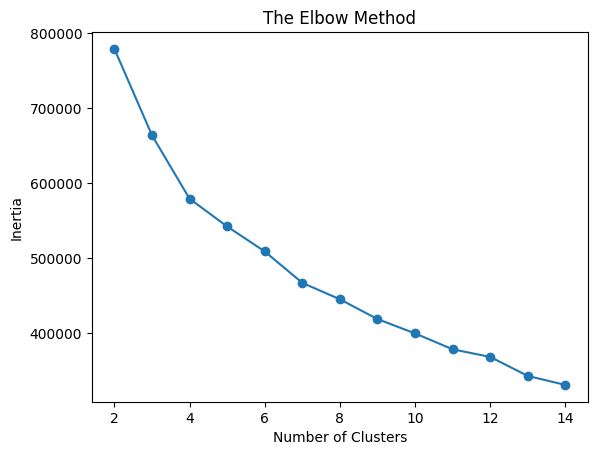

In [ ]:
inertia = []

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()].fillna(0)
column_names = g.columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)
normalized_df = pd.DataFrame(normalized_data, columns=column_names)
transposed_df = normalized_df.transpose()

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transposed_df)  # หรือ df.T
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()



---



<ipython-input-62-790cea2612ab>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['CTUN_As'] = result_df['CTUN_As'].combine_first(df['CTUN_Aspd'])


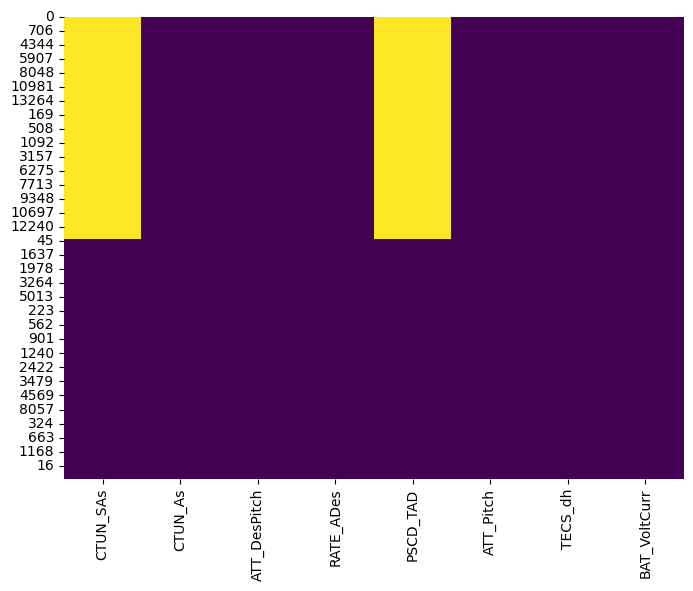

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+direct_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = [col for key, values in climb_direct.items() for col in values]
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

#4.0.8
result_df['CTUN_As'] = result_df['CTUN_As'].combine_first(df['CTUN_Aspd'])

plt.figure(figsize=(8, 6))
sns.heatmap(result_df.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-63-3cac63c3d4fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier as rfc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


sbs = SFS(#knn(n_neighbors=3),
           #rfc(n_jobs=8),
          # MLPClassifier(hidden_layer_sizes=1000),
           LinearRegression(),
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring = 'neg_mean_absolute_error',  # sklearn regressors
          #  scoring='accuracy',  # sklearn classifiers
           cv=3)
sbs = sbs.fit(X_scaled, y)


[2023-12-27 19:56:00] Features: 6/1 -- score: -233.33018236355187
[2023-12-27 19:56:00] Features: 5/1 -- score: -217.64145077603112
[2023-12-27 19:56:00] Features: 4/1 -- score: -214.5675951902225
[2023-12-27 19:56:00] Features: 3/1 -- score: -214.40203344309964
[2023-12-27 19:56:00] Features: 2/1 -- score: -222.3474755542101
[2023-12-27 19:56:00] Features: 1/1 -- score: -249.28053401657107

In [ ]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
7,"(0, 1, 2, 3, 4, 5, 6)",-257.035754
6,"(0, 1, 2, 3, 5, 6)",-233.330182
5,"(0, 1, 2, 3, 5)",-217.641451
4,"(0, 1, 2, 5)",-214.567595
3,"(0, 1, 2)",-214.402033
2,"(0, 2)",-222.347476
1,"(2,)",-249.280534


In [ ]:
sbs.subsets_


{7: {'feature_idx': (0, 1, 2, 3, 4, 5, 6),
  'cv_scores': array([-200.07255122, -236.2108023 , -334.82390889]),
  'avg_score': -257.0357541347385,
  'feature_names': ('CTUN_SAs',
   'CTUN_As',
   'ATT_DesPitch',
   'RATE_ADes',
   'PSCD_TAD',
   'ATT_Pitch',
   'TECS_dh')},
 6: {'feature_idx': (0, 1, 2, 3, 5, 6),
  'cv_scores': array([-201.16208192, -226.78063592, -272.04782925]),
  'avg_score': -233.33018236355187,
  'feature_names': ('CTUN_SAs',
   'CTUN_As',
   'ATT_DesPitch',
   'RATE_ADes',
   'ATT_Pitch',
   'TECS_dh')},
 5: {'feature_idx': (0, 1, 2, 3, 5),
  'cv_scores': array([-197.4693877 , -222.02732406, -233.42764058]),
  'avg_score': -217.64145077603112,
  'feature_names': ('CTUN_SAs',
   'CTUN_As',
   'ATT_DesPitch',
   'RATE_ADes',
   'ATT_Pitch')},
 4: {'feature_idx': (0, 1, 2, 5),
  'cv_scores': array([-200.45526362, -222.02631836, -221.2212036 ]),
  'avg_score': -214.5675951902225,
  'feature_names': ('CTUN_SAs', 'CTUN_As', 'ATT_DesPitch', 'ATT_Pitch')},
 3: {'feature_

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

efs = ExhaustiveFeatureSelector(
           #knn(n_neighbors=3),
           #rfc(n_jobs=8),
           LinearRegression(),
          max_features=len(X.columns),
          scoring='neg_mean_absolute_error',  # ใช้ neg_mean_absolute_error
          cv=3,
          n_jobs=-1)

efs = efs.fit(X, y)


Features: 127/127

In [ ]:
efs.best_feature_names_


('CTUN_SAs', 'CTUN_As', 'ATT_DesPitch')

# climb_turn

In [ ]:
list_df = []

filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+turn_phase.csv"

# print(filename)
all_parameter_df = pd.read_csv(filename,index_col=0)
all_parameter_df = all_parameter_df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

df = all_parameter_df
df.fillna(0, inplace=True)
df = df.loc[:, (df != 0).any(axis=0)] #ลบทุก column ที่ทุก row = 0

df_corr = df.copy()
correlation_all_parameter = df_corr.corr()

correlation_with_powr = correlation_all_parameter.loc[correlation_all_parameter.index != 'BAT_VoltCurr', 'BAT_VoltCurr'].to_frame()  #ในข้อมูลพี่ริว คือ 21
correlation_with_powr['Abs_Corr'] = correlation_with_powr["BAT_VoltCurr"].abs()

sorted_correlation_with_powr = correlation_with_powr.sort_values(by='Abs_Corr', ascending=False).copy()
sorted_correlation_with_powr.drop('Abs_Corr',axis = 1 ,inplace = True)
sorted_correlation_with_rank = sorted_correlation_with_powr.iloc[:100].copy()
sorted_correlation_with_rank.loc[:, 'rank'] = range(1, 101)
sorted_correlation_with_rank.drop('BAT_VoltCurr',axis = 1 ,inplace = True)



In [ ]:
sorted_correlation_with_rank.index.tolist()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]

column_names = g.columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)

normalized_df = pd.DataFrame(normalized_data, columns=column_names)

In [ ]:
transposed_df = normalized_df.transpose()

kmeans = KMeans(n_clusters=5)

transposed_df['Cluster'] = kmeans.fit_predict(transposed_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
unique_clusters = transposed_df.iloc[:,-1].unique()
unique_clusters

array([4, 2, 3, 0, 1], dtype=int32)

In [ ]:
for cluster, data in transposed_df.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{data.index.tolist()}\n")

Cluster 0:
['PM_I2CC', 'GPA_SMS', 'MAG_S', 'BARO_SMS', 'IOMC_TS', 'IOMC_NPkt', 'PM_SPIC', 'PIQA_Tar', 'PIQA_Err', 'PIQA_P', 'XKF1_dPD', 'NK13_IYAW', 'MAG2_S', 'BAR2_SMS', 'XKF7_MD', 'XKF8_IYAW', 'RATE_ADes', 'NK12_MD', 'XKF1_VD', 'XKF3_IYAW', 'GPS_VZ', 'BAR2_Alt', 'BAR2_GndTemp', 'NKT1_AngMin', 'NKT1_VMin', 'XKF9_errRP', 'PSCN_DAN', 'PSCN_TVN', 'PSCN_DVN', 'PSCN_VN']

Cluster 1:
['PSCD_TAD', 'XKV2_V23', 'CTUN_ThO', 'TECS_dh', 'TECS_spdem', 'RCIN_C1', 'XKF2_AZ', 'XKV2_V17', 'XKV2_V15', 'CMD_CId', 'RATE_ROut', 'AUXF_function', 'XKF6_PD', 'NK11_PD', 'PIDP_SRate', 'NK11_GZ', 'XKV1_V02', 'CAM_Yaw', 'XKV1_V10', 'XKV2_V12', 'PSCE_AE', 'PSCE_DAE', 'PSCE_DVE', 'PSCE_TVE']

Cluster 2:
['TECS_sp', 'NTUN_AspdE', 'TEC2_EDelta', 'BAT_EnrgTot', 'BAT_CurrTot', 'RAD_RxErrors', 'CTUN_ThrDem', 'RATE_P', 'MAVC_Cmd', 'MAG2_OfsY', 'XKF6_OH', 'NK11_OH', 'CTRL_RMSPitchD', 'RCIN_C5', 'ATT_ErrRP', 'QTUN_ABst']

Cluster 3:
['BAT_VoltR', 'PIQR_I', 'TECS_dsp', 'RCIN_C3', 'NK12_GSZ', 'XKF2_GSZ', 'XKF2_GSY', 'UBX1_a

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

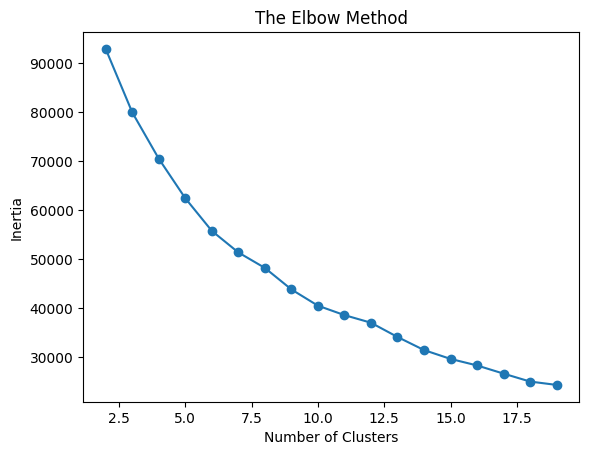

In [ ]:
inertia = []

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]
column_names = g.columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)
normalized_df = pd.DataFrame(normalized_data, columns=column_names)
transposed_df = normalized_df.transpose()

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transposed_df)  # หรือ df.T
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()




---



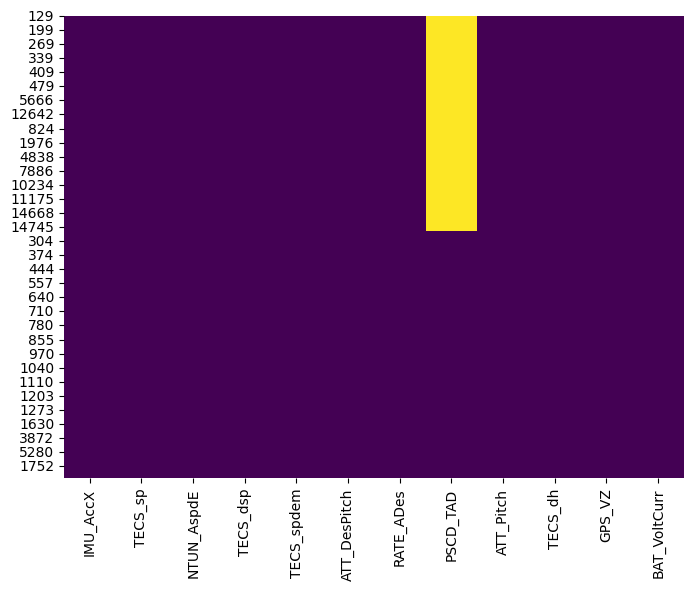

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+turn_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = [col for key, values in climb_turn.items() for col in values]
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

plt.figure(figsize=(8, 6))
sns.heatmap(result_df.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
feature_names = tuple(X.columns)


<ipython-input-86-5d634dbd1792>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
model = RandomForestRegressor()

model.fit(X, y)
feature_importance = model.feature_importances_
feature_importance

array([0.17337177, 0.71034214, 0.05681467, 0.0024186 , 0.00495301,
       0.0030636 , 0.00172249, 0.02665955, 0.00946797, 0.00197458,
       0.00921162])

In [ ]:
for feature, importance in zip(X.columns, feature_importance):
    print(f'{feature}: {importance}')

IMU_AccX: 0.18113125705502384
TECS_sp: 0.7062725651657039
NTUN_AspdE: 0.07480694057651754
TECS_dsp: 0.0026691284225829836
TECS_spdem: 0.008243674365285631
ATT_Pitch: 0.005332974679589321
TECS_dh: 0.004071406506772582
AHR2_Pitch: 0.009222753814726559
ATT_DesPitch: 0.00824929941379763


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier as rfc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


sbs = SFS(#knn(n_neighbors=3),
           #rfc(n_jobs=8),
          # MLPRegressor(hidden_layer_sizes=(10, ), activation='relu', random_state=42),
           LinearRegression(),
          # RandomForestRegressor(),
          # SVR(gamma='scale'),
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring = 'neg_mean_absolute_error',  # sklearn regressors
          #  scoring='accuracy',  # sklearn classifiers
           cv=3)
sbs = sbs.fit(X, y)


[2023-12-28 08:34:45] Features: 10/1 -- score: -90.38916123935758
[2023-12-28 08:34:45] Features: 9/1 -- score: -86.4192809091957
[2023-12-28 08:34:45] Features: 8/1 -- score: -81.79176530312584
[2023-12-28 08:34:45] Features: 7/1 -- score: -80.40929888664927
[2023-12-28 08:34:45] Features: 6/1 -- score: -79.76710508306728
[2023-12-28 08:34:45] Features: 5/1 -- score: -77.38644453270332
[2023-12-28 08:34:45] Features: 4/1 -- score: -78.53718965413162
[2023-12-28 08:34:45] Features: 3/1 -- score: -79.58956148652733
[2023-12-28 08:34:45] Features: 2/1 -- score: -84.9903150321077
[2023-12-28 08:34:45] Features: 1/1 -- score: -135.761109669776

In [ ]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
11,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",-104.911771
10,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10)",-90.389161
9,"(0, 1, 2, 4, 5, 6, 8, 9, 10)",-86.419281
8,"(0, 1, 2, 4, 5, 8, 9, 10)",-81.791765
7,"(0, 1, 2, 4, 8, 9, 10)",-80.409299
6,"(0, 1, 2, 8, 9, 10)",-79.767105
5,"(0, 1, 2, 8, 10)",-77.386445
4,"(0, 1, 2, 10)",-78.53719
3,"(0, 1, 2)",-79.589561
2,"(0, 2)",-84.990315


In [ ]:
sbs.subsets_


{11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
  'cv_scores': array([-130.60923372,  -72.78350888, -111.34257023]),
  'avg_score': -104.91177094356726,
  'feature_names': ('IMU_AccX',
   'TECS_sp',
   'NTUN_AspdE',
   'TECS_dsp',
   'TECS_spdem',
   'ATT_DesPitch',
   'RATE_ADes',
   'PSCD_TAD',
   'ATT_Pitch',
   'TECS_dh',
   'GPS_VZ')},
 10: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 8, 9, 10),
  'cv_scores': array([ -92.67516399,  -75.62497578, -102.86734395]),
  'avg_score': -90.38916123935758,
  'feature_names': ('IMU_AccX',
   'TECS_sp',
   'NTUN_AspdE',
   'TECS_dsp',
   'TECS_spdem',
   'ATT_DesPitch',
   'RATE_ADes',
   'ATT_Pitch',
   'TECS_dh',
   'GPS_VZ')},
 9: {'feature_idx': (0, 1, 2, 4, 5, 6, 8, 9, 10),
  'cv_scores': array([ -80.98253998,  -74.86043609, -103.41486666]),
  'avg_score': -86.4192809091957,
  'feature_names': ('IMU_AccX',
   'TECS_sp',
   'NTUN_AspdE',
   'TECS_spdem',
   'ATT_DesPitch',
   'RATE_ADes',
   'ATT_Pitch',
   'TECS_dh',
   'GPS_VZ')},
 8

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

efs = ExhaustiveFeatureSelector(
           #knn(n_neighbors=3),
           #rfc(n_jobs=8),
           LinearRegression(),
          # max_features=len(X.columns),
           max_features=2,
          scoring='neg_mean_absolute_error',  # ใช้ neg_mean_absolute_error
          cv=3,
          n_jobs=-1)

# efs = efs.fit(X[['IMU_AccX', 'NTUN_AspdE', 'ATT_DesPitch', 'TECS_sp']], y)
efs = efs.fit(X, y)


Features: 66/66

In [ ]:
efs.best_feature_names_


('IMU_AccX', 'NTUN_AspdE')

In [ ]:
efs.subsets_

{0: {'feature_idx': (0,),
  'cv_scores': array([-179.05624302, -135.52652578,  -92.70056021]),
  'avg_score': -135.761109669776,
  'feature_names': ('IMU_AccX',)},
 1: {'feature_idx': (1,),
  'cv_scores': array([-169.08867741, -216.86371229, -152.21040589]),
  'avg_score': -179.3875985289969,
  'feature_names': ('TECS_sp',)},
 2: {'feature_idx': (2,),
  'cv_scores': array([-191.84831708, -220.91277758, -146.88163603]),
  'avg_score': -186.54757689561134,
  'feature_names': ('NTUN_AspdE',)},
 3: {'feature_idx': (3,),
  'cv_scores': array([-165.71127691, -268.96543136, -182.74907437]),
  'avg_score': -205.8085942156798,
  'feature_names': ('TECS_dsp',)},
 4: {'feature_idx': (4,),
  'cv_scores': array([-418.36101866, -302.43999244, -175.83980413]),
  'avg_score': -298.8802717436975,
  'feature_names': ('TECS_spdem',)},
 5: {'feature_idx': (5,),
  'cv_scores': array([-207.97911714, -290.97275862, -242.49486902]),
  'avg_score': -247.14891492955917,
  'feature_names': ('ATT_DesPitch',)},
 6

In [ ]:
df = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df.sort_values(by='avg_score', ascending=False)

,feature_idx,avg_score
12,"(0, 2)",-84.990315
11,"(0, 1)",-96.446806
42,"(3, 8)",-125.052417
20,"(0, 10)",-131.399517
15,"(0, 5)",-133.882191
...,...,...
58,"(6, 9)",-328.04321
7,"(7,)",-352.504809
56,"(6, 7)",-367.351445
61,"(7, 9)",-372.746446




---



# noclimb_direct

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+direct_phase.csv"

# print(filename)
all_parameter_df = pd.read_csv(filename,index_col=0)
all_parameter_df = all_parameter_df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

In [ ]:
df = all_parameter_df
df.fillna(0, inplace=True)
df = df.loc[:, (df != 0).any(axis=0)] #ลบทุก column ที่ทุก row = 0

df_corr = df.copy()
correlation_all_parameter = df_corr.corr()

correlation_with_powr = correlation_all_parameter.loc[correlation_all_parameter.index != 'BAT_VoltCurr', 'BAT_VoltCurr'].to_frame()  #ในข้อมูลพี่ริว คือ 21
correlation_with_powr['Abs_Corr'] = correlation_with_powr["BAT_VoltCurr"].abs()

sorted_correlation_with_powr = correlation_with_powr.sort_values(by='Abs_Corr', ascending=False).copy()
sorted_correlation_with_powr.drop('Abs_Corr',axis = 1 ,inplace = True)
sorted_correlation_with_rank = sorted_correlation_with_powr.iloc[:100].copy()
sorted_correlation_with_rank.loc[:, 'rank'] = range(1, 101)
sorted_correlation_with_rank.drop('BAT_VoltCurr',axis = 1 ,inplace = True)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]

column_names = g.columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)

normalized_df = pd.DataFrame(normalized_data, columns=column_names)

transposed_df = normalized_df.transpose()

kmeans = KMeans(n_clusters=6)

transposed_df['Cluster'] = kmeans.fit_predict(transposed_df)

for cluster, data in transposed_df.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{data.index.tolist()}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
['TECS_ph', 'TEC2_PErr', 'GPS_Spd', 'TECS_sp', 'ARSP_Airspeed', 'TEC2_EDelta', 'AOA_SSA', 'TECS_spdem', 'AETR_Elev', 'STAT_isFlyProb', 'ARSP_DiffPress', 'ARM_ArmChecks', 'CMD_Alt', 'POWR_VServo', 'PIDP_I', 'PIQP_Err', 'TECS_w', 'PIQP_P', 'PIDP_P']

Cluster 1:
['ATT_DesYaw', 'CMD_CId', 'NTUN_AspdE', 'QTUN_ThO', 'TEC2_KErr', 'TECS_th', 'RATE_AOut', 'RCOU_C7', 'RCOU_C8', 'RCOU_C6', 'RCOU_C5', 'XKY0_W2', 'DSF_Blk', 'RCOU_C10', 'DSF_Bytes', 'AETR_SS']

Cluster 2:
['BAT_Curr', 'RCOU_C14', 'RCOU_C13', 'RCOU_C9', 'AETR_Thr', 'IMU_AccX', 'TECS_iph', 'CTUN_NavPitch', 'ATT_DesPitch', 'TECS_dhdem', 'CTUN_Pitch', 'XKF1_Pitch', 'ATT_Pitch', 'AHR2_Pitch', 'BARO_CRt', 'TECS_dh', 'CAM_Pitch', 'XKF6_Pitch', 'NK11_Pitch', 'XKF3_IPD']

Cluster 3:
['PSCD_DAD', 'CTUN_ThO', 'PSCD_AD', 'TECS_ith', 'RATE_RDes', 'QTUN_CRt', 'CTRL_RMSRollD', 'QTUN_DCRt', 'XKQ_Q4', 'PIQR_Tar', 'CTRL_RMSRollP', 'PSCN_VN', 'PSCN_DVN', 'PSCN_TVN', 'PSCN_DAN', 'RATE_ROut', 'XKY0_W0', 'PIQR_D']

Cluster 4:
['BAT_Volt', 'PSC

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

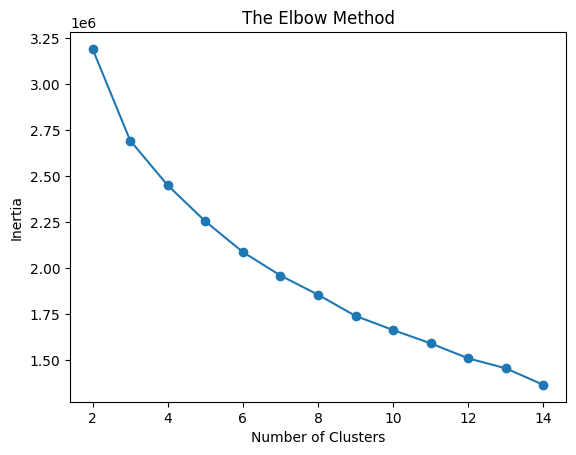

In [ ]:
inertia = []

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()].fillna(0)
column_names = g.columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)
normalized_df = pd.DataFrame(normalized_data, columns=column_names)
transposed_df = normalized_df.transpose()

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transposed_df)  # หรือ df.T
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

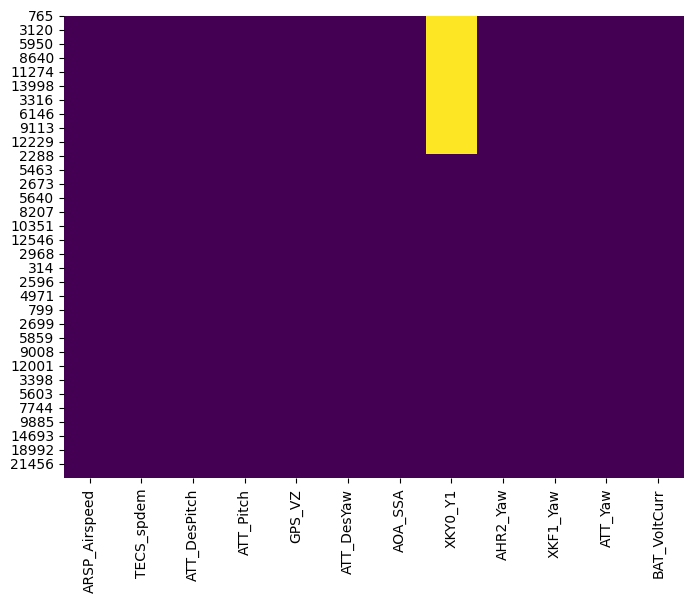

In [ ]:
# filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+direct_phase.csv"
folders = ["drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode",
           "drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new"]

df_filter_mode = pd.DataFrame()


for folder in folders:
    files = glob.glob(f"{folder}/*.csv")
    for file in files:
      df = pd.read_csv(file)
      #for 4.1.5
      columns_to_remove = df.filter(regex=r'\[.*[1-9].*\]').columns #ลบที่ไม่ใช่ [0]
      df.drop(columns=columns_to_remove, inplace=True)

      df.rename(columns=lambda x: x.replace(r'[0]', ''), inplace=True)

      #for 4.0.8
      columns_to_remove = df.filter(regex=r'^IMU(\d+)').columns
      df.drop(columns=columns_to_remove, inplace=True)
      df.rename(columns=lambda x: re.sub(r'^NKF(\d+)', r'XKF\1', x), inplace=True)
      df.rename(columns=lambda x: re.sub(r'CTUN_Aspd', r'CTUN_As', x), inplace=True)

      filtered_df = df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)
      df_filter_mode = pd.concat([df_filter_mode, filtered_df])

condition_no_climb_direct = (df_filter_mode['ATT_Roll'] <= 10) & (df_filter_mode['TECS_dh'] < 1)
df_no_climb_direct = df_filter_mode[condition_no_climb_direct].copy()
df = df_no_climb_direct

# df = pd.read_csv(filename,index_col=0)
selected_columns = [col for key, values in noclimb_direct.items() for col in values]
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

plt.figure(figsize=(8, 6))
sns.heatmap(result_df.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

mean_y1 = result_df['XKY0_Y1'].mean()
result_df['XKY0_Y1'].fillna(mean_y1, inplace=True)
result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
feature_names = tuple(X.columns)


<ipython-input-102-89e2256f9f26>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['XKY0_Y1'].fillna(mean_y1, inplace=True)
<ipython-input-102-89e2256f9f26>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier as rfc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


sbs = SFS(#knn(n_neighbors=3),
           #rfc(n_jobs=8),
          # MLPRegressor(hidden_layer_sizes=(10, ), activation='relu', random_state=42),
           LinearRegression(),
          # SVR(gamma='scale'),
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring = 'neg_mean_absolute_error',  # sklearn regressors
          #  scoring='accuracy',  # sklearn classifiers
           cv=3)
sbs = sbs.fit(X_scaled, y)


[2024-01-11 02:51:25] Features: 10/1 -- score: -127.54836478570991
[2024-01-11 02:51:27] Features: 9/1 -- score: -127.54367899077424
[2024-01-11 02:51:29] Features: 8/1 -- score: -127.54489876085584
[2024-01-11 02:51:30] Features: 7/1 -- score: -125.39453238874016
[2024-01-11 02:51:31] Features: 6/1 -- score: -125.48686156881412
[2024-01-11 02:51:32] Features: 5/1 -- score: -126.27127557324813
[2024-01-11 02:51:33] Features: 4/1 -- score: -126.80679998961902
[2024-01-11 02:51:33] Features: 3/1 -- score: -130.2600546755665
[2024-01-11 02:51:34] Features: 2/1 -- score: -133.7712801570308
[2024-01-11 02:51:34] Features: 1/1 -- score: -163.13888827258128

In [ ]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
11,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",-128.105415
10,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",-127.548365
9,"(1, 2, 3, 4, 5, 6, 7, 8, 10)",-127.543679
8,"(1, 2, 3, 4, 5, 6, 7, 10)",-127.544899
7,"(1, 2, 3, 4, 5, 6, 7)",-125.394532
6,"(1, 2, 3, 5, 6, 7)",-125.486862
5,"(1, 2, 5, 6, 7)",-126.271276
4,"(1, 2, 5, 7)",-126.8068
3,"(2, 5, 7)",-130.260055
2,"(2, 5)",-133.77128


In [ ]:
sbs.subsets_


{11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
  'cv_scores': array([-129.75845196, -133.64913579, -120.90865615]),
  'avg_score': -128.1054146313206,
  'feature_names': ('ARSP_Airspeed',
   'TECS_spdem',
   'ATT_DesPitch',
   'ATT_Pitch',
   'GPS_VZ',
   'ATT_DesYaw',
   'AOA_SSA',
   'XKY0_Y1',
   'AHR2_Yaw',
   'XKF1_Yaw',
   'ATT_Yaw')},
 10: {'feature_idx': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
  'cv_scores': array([-129.44203031, -135.43909903, -117.76396502]),
  'avg_score': -127.54836478570991,
  'feature_names': ('TECS_spdem',
   'ATT_DesPitch',
   'ATT_Pitch',
   'GPS_VZ',
   'ATT_DesYaw',
   'AOA_SSA',
   'XKY0_Y1',
   'AHR2_Yaw',
   'XKF1_Yaw',
   'ATT_Yaw')},
 9: {'feature_idx': (1, 2, 3, 4, 5, 6, 7, 8, 10),
  'cv_scores': array([-129.42858242, -135.43857107, -117.76388349]),
  'avg_score': -127.54367899077424,
  'feature_names': ('TECS_spdem',
   'ATT_DesPitch',
   'ATT_Pitch',
   'GPS_VZ',
   'ATT_DesYaw',
   'AOA_SSA',
   'XKY0_Y1',
   'AHR2_Yaw',
   'ATT_Yaw')},
 

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

efs = ExhaustiveFeatureSelector(
           #knn(n_neighbors=3),
           #rfc(n_jobs=8),
           LinearRegression(),
          # max_features=len(X.columns),
           max_features=3,
          scoring='neg_mean_absolute_error',  # ใช้ neg_mean_absolute_error
          cv=3,
          n_jobs=-1)

efs = efs.fit(X_scaled, y)


Features: 92/92

In [ ]:
efs.best_feature_names_


('TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1')

In [ ]:
f = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
8,"(0, 1, 2, 3, 4, 5, 6, 7)",-140.838014
7,"(0, 1, 2, 3, 4, 6, 7)",-132.93759
6,"(1, 2, 3, 4, 6, 7)",-124.716357
5,"(1, 2, 4, 6, 7)",-125.578722
4,"(1, 2, 6, 7)",-125.226015
3,"(1, 2, 7)",-126.526204
2,"(1, 2)",-128.283721
1,"(2,)",-137.456196


# noclimb_turn

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+turn_phase.csv"

# print(filename)
all_parameter_df = pd.read_csv(filename,index_col=0)
all_parameter_df = all_parameter_df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

In [ ]:
df = all_parameter_df
df.fillna(0, inplace=True)
df = df.loc[:, (df != 0).any(axis=0)] #ลบทุก column ที่ทุก row = 0

df_corr = df.copy()
correlation_all_parameter = df_corr.corr()

correlation_with_powr = correlation_all_parameter.loc[correlation_all_parameter.index != 'BAT_VoltCurr', 'BAT_VoltCurr'].to_frame()  #ในข้อมูลพี่ริว คือ 21
correlation_with_powr['Abs_Corr'] = correlation_with_powr["BAT_VoltCurr"].abs()

sorted_correlation_with_powr = correlation_with_powr.sort_values(by='Abs_Corr', ascending=False).copy()
sorted_correlation_with_powr.drop('Abs_Corr',axis = 1 ,inplace = True)
sorted_correlation_with_rank = sorted_correlation_with_powr.iloc[:100].copy()
sorted_correlation_with_rank.loc[:, 'rank'] = range(1, 101)
sorted_correlation_with_rank.drop('BAT_VoltCurr',axis = 1 ,inplace = True)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]

column_names = g.columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)

normalized_df = pd.DataFrame(normalized_data, columns=column_names)

transposed_df = normalized_df.transpose()

kmeans = KMeans(n_clusters=6)

transposed_df['Cluster'] = kmeans.fit_predict(transposed_df)

for cluster, data in transposed_df.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{data.index.tolist()}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
['XKF1_dPD', 'XKF1_VD', 'GPS_VZ', 'XKF6_dPD', 'NK11_dPD', 'RCIN_C2', 'NK11_VD', 'XKF6_VD']

Cluster 1:
['ATT_DesPitch', 'CTUN_NavPitch', 'XKF1_Pitch', 'ATT_Pitch', 'CTUN_Pitch', 'AHR2_Pitch', 'BARO_CRt', 'NK11_Pitch', 'XKF6_Pitch', 'TECS_dh', 'BAR2_CRt']

Cluster 2:
['BAT_Curr', 'RCOU_C14', 'RCOU_C13', 'AETR_Thr', 'RCOU_C9', 'TECS_th', 'IMU_AccX', 'TEC2_PErr', 'TECS_ith', 'TECS_dsp', 'PSCD_AD', 'XKF3_IPD', 'TECS_dhdem', 'PSCD_DAD', 'XKF4_SM', 'PSCN_TVN', 'PSCN_VN', 'PSCN_DVN', 'RCIN_C7', 'PSCN_DAN', 'AHR2_Q3', 'RATE_YOut', 'CAM_Roll', 'NTUN_AltErr', 'RATE_RDes', 'QTUN_CRt', 'XKY1_IVN2', 'POWR_VServo', 'XKF8_IPD', 'PSCN_AN', 'AOA_AOA', 'XKY1_IVN3', 'NTUN_AspdE', 'XKY0_W1', 'TECS_iph']

Cluster 3:
['TEC2_LF', 'PIDP_Tar', 'AETR_Elev', 'CTUN_NavRoll', 'ATT_DesRoll', 'ATT_Roll', 'XKF1_Roll', 'CTUN_Roll', 'AHR2_Roll', 'TECS_ph', 'IMU_GyrZ', 'IMU_GyrY', 'PIDP_Act', 'PIDP_P']

Cluster 4:
['CTUN_ThO', 'CTUN_ThD', 'PIDP_FF', 'XKF1_PN', 'PIDP_Err', 'XKF2_AY', 'XKY0_W0', 'CTRL_RMSYaw', 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

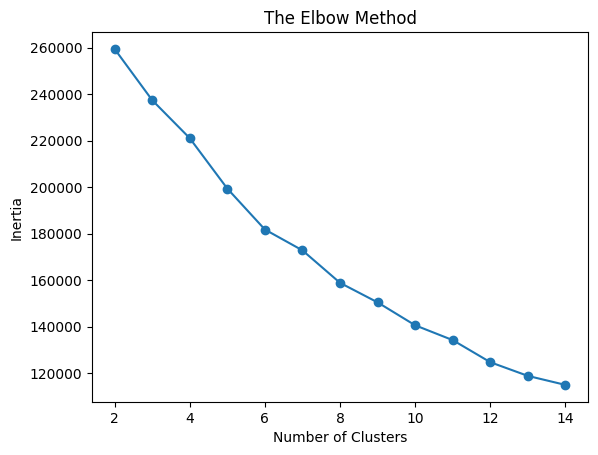

In [ ]:
inertia = []

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()].fillna(0)
column_names = g.columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)
normalized_df = pd.DataFrame(normalized_data, columns=column_names)
transposed_df = normalized_df.transpose()

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transposed_df)  # หรือ df.T
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

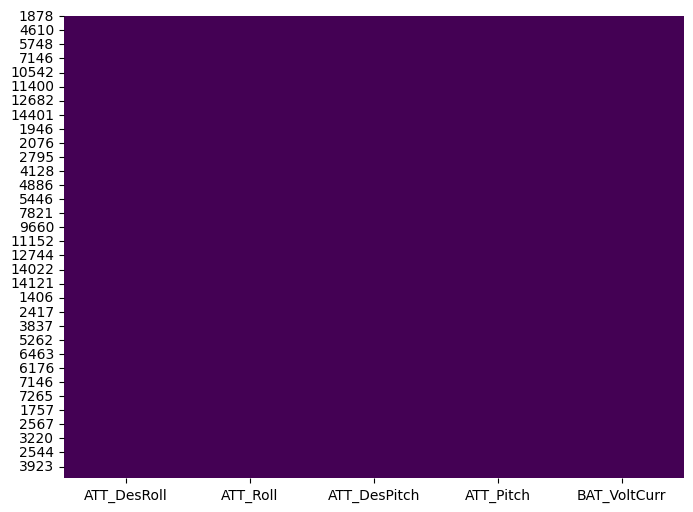

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+turn_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = [col for key, values in noclimb_turn.items() for col in values]
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

plt.figure(figsize=(8, 6))
sns.heatmap(result_df.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
feature_names = tuple(X.columns)


<ipython-input-28-5d634dbd1792>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier as rfc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


sbs = SFS(#knn(n_neighbors=3),
           #rfc(n_jobs=8),
          # MLPRegressor(hidden_layer_sizes=(10, ), activation='relu', random_state=42),
           LinearRegression(),
          # SVR(gamma='scale'),
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring = 'neg_mean_absolute_error',  # sklearn regressors
          #  scoring='accuracy',  # sklearn classifiers
           cv=3)
sbs = sbs.fit(X_scaled, y)


[2024-01-03 15:58:19] Features: 3/1 -- score: -141.78159327462996
[2024-01-03 15:58:19] Features: 2/1 -- score: -142.3148868720787
[2024-01-03 15:58:19] Features: 1/1 -- score: -141.47349924748457

In [ ]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
4,"(0, 1, 2, 3)",-142.255864
3,"(0, 1, 2)",-141.781593
2,"(1, 2)",-142.314887
1,"(2,)",-141.473499


In [ ]:
sbs.subsets_


{4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([-133.91584459, -149.56876153, -143.28298593]),
  'avg_score': -142.25586401784594,
  'feature_names': ('ATT_DesRoll', 'ATT_Roll', 'ATT_DesPitch', 'ATT_Pitch')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([-132.98255083, -149.64063579, -142.7215932 ]),
  'avg_score': -141.78159327462996,
  'feature_names': ('ATT_DesRoll', 'ATT_Roll', 'ATT_DesPitch')},
 2: {'feature_idx': (1, 2),
  'cv_scores': array([-134.11302229, -147.65018139, -145.18145693]),
  'avg_score': -142.3148868720787,
  'feature_names': ('ATT_Roll', 'ATT_DesPitch')},
 1: {'feature_idx': (2,),
  'cv_scores': array([-134.59646947, -143.18159709, -146.64243118]),
  'avg_score': -141.47349924748457,
  'feature_names': ('ATT_DesPitch',)}}

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

efs = ExhaustiveFeatureSelector(
           #knn(n_neighbors=3),
           #rfc(n_jobs=8),
           LinearRegression(),
          # max_features=len(X.columns),
           max_features=2,
          scoring='neg_mean_absolute_error',  # ใช้ neg_mean_absolute_error
          cv=3,
          n_jobs=-1)

efs = efs.fit(X_scaled, y)


Features: 10/10

In [ ]:
efs.best_feature_names_


('TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1')

In [ ]:
f = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
8,"(0, 1, 2, 3, 4, 5, 6, 7)",-140.838014
7,"(0, 1, 2, 3, 4, 6, 7)",-132.93759
6,"(1, 2, 3, 4, 6, 7)",-124.716357
5,"(1, 2, 4, 6, 7)",-125.578722
4,"(1, 2, 6, 7)",-125.226015
3,"(1, 2, 7)",-126.526204
2,"(1, 2)",-128.283721
1,"(2,)",-137.456196


# model climb_direct

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+direct_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = ['CTUN_SAs', 'ATT_DesPitch']
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-118-bb28f24a04ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(10,))))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)  # Use KFold instead of StratifiedKFold
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')  # Use regression metric (e.g., neg_mean_squared_error)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))  # Note: negative of mean squared error is used


LR: 202.107003 (5.216170)
DT: 97.082917 (2.480685)
RF: 103.421688 (3.229807)
KNN: 128.644947 (2.923832)
SVR: 181.344810 (5.452186)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP: 187.419409 (7.062896)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


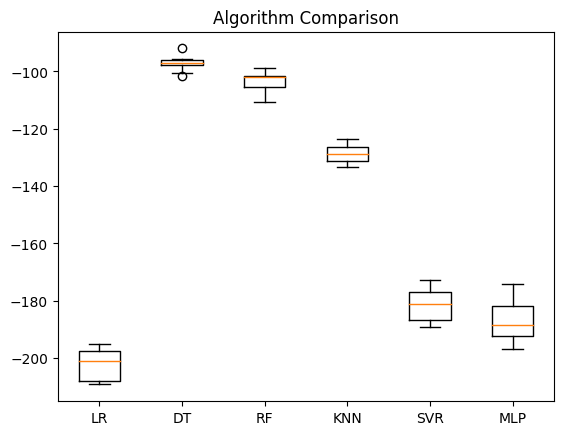

In [ ]:
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
model_phase_CD = DecisionTreeRegressor()
model_phase_CD.fit(X, y)


DecisionTreeRegressor()

# model climb_turn

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+turn_phase.csv"
df = pd.read_csv(filename,index_col=0)
# selected_columns = ['IMU_AccX', 'AHR2_Pitch']
selected_columns = ['TECS_dsp', 'ATT_Pitch']

selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-96-818f86823b35>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(10,))))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)  # Use KFold instead of StratifiedKFold
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')  # Use regression metric (e.g., neg_mean_squared_error)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))  # Note: negative of mean squared error is used


LR: 117.432228 (5.604889)
DT: 84.929929 (4.816156)
RF: 75.818733 (3.697888)
KNN: 93.201952 (5.971340)
SVR: 260.187711 (5.866292)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP: 463.250145 (83.457249)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


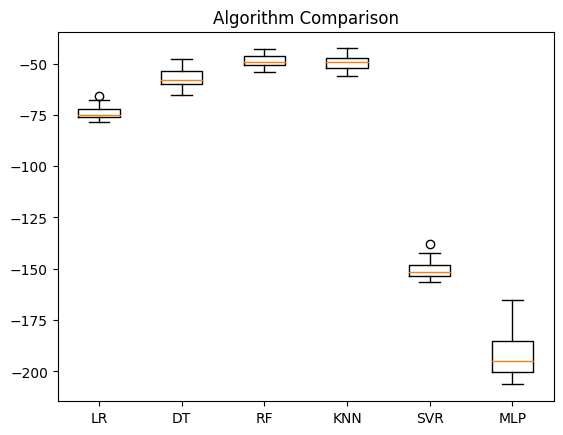

In [ ]:
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
model_phase_CT = DecisionTreeRegressor()
model_phase_CT.fit(X, y)


DecisionTreeRegressor()

# model noclimb_direct

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+direct_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = ['TECS_spdem', 'ATT_DesPitch', 'AOA_SSA']

selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-94-8511224fc388>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]

In [ ]:
X

,TECS_spdem,ATT_DesPitch,AOA_SSA
765,21.08141,-9.63,-2.397751
766,21.12330,-5.79,-2.677083
767,21.16256,-5.69,-3.582273
768,21.20037,-2.34,-4.006880
769,21.23751,-2.44,-4.383528
...,...,...,...
23682,19.59300,-0.58,-46.836710
23683,19.59300,-0.58,-46.909760
23684,19.59300,-0.54,-46.817490
23685,19.59300,-0.59,-46.897940


In [ ]:
selected_columns = ['TECS_spdem', 'ATT_DesPitch', 'AOA_SSA']

X = X[selected_columns]
X.fillna(0,inplace=True)


# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# feature_names = tuple(X.columns)

<ipython-input-124-5241ea3022a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0,inplace=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(3,))))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)  # Use KFold instead of StratifiedKFold
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')  # Use regression metric (e.g., neg_mean_squared_error)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))  # Note: negative of mean squared error is used


LR: 138.737026 (1.087180)
DT: 60.095442 (0.679427)
RF: 55.018722 (0.534699)
KNN: 86.710837 (0.973715)


KeyboardInterrupt: 

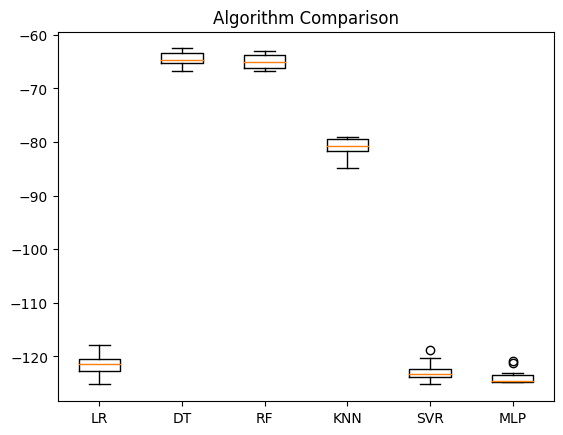

In [ ]:
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
model_phase_NCD = DecisionTreeRegressor()
model_phase_NCD.fit(X, y)


DecisionTreeRegressor()

# model noclimb_turn

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+turn_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = ['ATT_Roll', 'ATT_DesPitch']

selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-42-1b308dbff122>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(10,))))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)  # Use KFold instead of StratifiedKFold
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')  # Use regression metric (e.g., neg_mean_squared_error)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))  # Note: negative of mean squared error is used


LR: 130.859413 (7.863784)
DT: 108.463804 (8.539796)
RF: 103.111432 (5.006395)
KNN: 122.298994 (5.021779)
SVR: 142.028165 (7.864985)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP: 169.012284 (8.714875)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


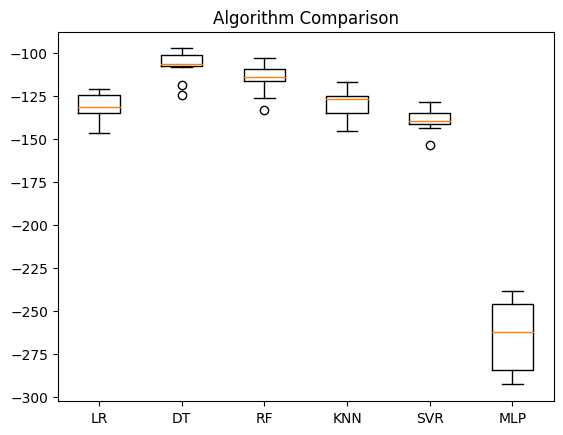

In [ ]:
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
model_phase_NCT = RandomForestRegressor()
model_phase_NCT.fit(X, y)


RandomForestRegressor()

# total

In [ ]:
# files = glob.glob(f"drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/*.csv")
folders = ["drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode",
           "drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new"]

phase_df = pd.DataFrame()

for folder in folders:
    files = glob.glob(f"{folder}/*.csv")
    for file in files:
        df = pd.read_csv(file)
        print(file,df.shape)

drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/00000021.csv (14639, 560)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/00000132.csv (14766, 573)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/00000152.csv (6819, 636)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/00000153.csv (13165, 644)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/00000154.csv (5116, 644)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/00000155.csv (6417, 644)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new/00000173.csv (1595, 634)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new/00000182.csv (17, 527)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new/00000185.csv (14179, 635)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new/00000186.csv (0, 527)
drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new/00000201.csv (23687, 633)


In [ ]:
# files = glob.glob(f"drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/*.csv")
folders = ["drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode",
           "drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new"]

df_filter_mode = pd.DataFrame()


for folder in folders:
    files = glob.glob(f"{folder}/*.csv")
    for file in files:
      df = pd.read_csv(file)
      #for 4.1.5
      columns_to_remove = df.filter(regex=r'\[.*[1-9].*\]').columns #ลบที่ไม่ใช่ [0]
      df.drop(columns=columns_to_remove, inplace=True)

      df.rename(columns=lambda x: x.replace(r'[0]', ''), inplace=True)

      #for 4.0.8
      columns_to_remove = df.filter(regex=r'^IMU(\d+)').columns
      df.drop(columns=columns_to_remove, inplace=True)
      df.rename(columns=lambda x: re.sub(r'^NKF(\d+)', r'XKF\1', x), inplace=True)
      df.rename(columns=lambda x: re.sub(r'CTUN_Aspd', r'CTUN_As', x), inplace=True)

      filtered_df = df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)
      df_filter_mode = pd.concat([df_filter_mode, filtered_df])

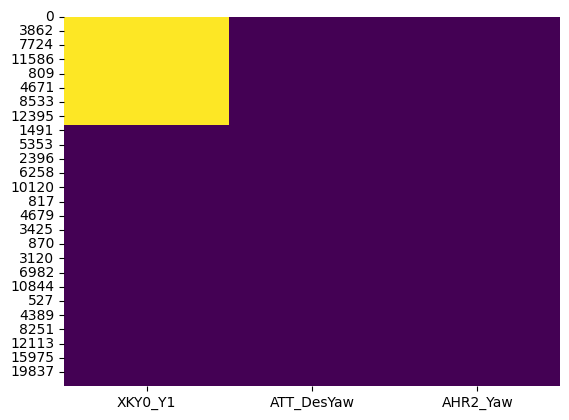

In [ ]:
# x = df_filter_mode.filter(regex='CTUN_.*', axis=1)
x = df_filter_mode[['XKY0_Y1','ATT_DesYaw','AHR2_Yaw']]

plt.figure()
sns.heatmap(x.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
df_filter_mode.filter(regex='CTUN_.*', axis=1)

,CTUN_NavRoll,CTUN_Roll,CTUN_NavPitch,CTUN_Pitch,CTUN_ThrOut,CTUN_RdrOut,CTUN_ThrDem,CTUN_Aspd,CTUN_ThO,CTUN_ThD,CTUN_As,CTUN_SAs,CTUN_E2T
0,0.00,-0.45,-4.78,-4.59,65.0,-192,0.0,3.857146,NaN,NaN,NaN,NaN,NaN
1,0.00,-0.31,-4.53,-4.77,65.0,-29,0.0,3.584720,NaN,NaN,NaN,NaN,NaN
2,0.00,-0.02,-4.49,-4.53,65.0,-103,0.0,3.223958,NaN,NaN,NaN,NaN,NaN
3,0.00,-0.21,-4.58,-4.52,65.0,178,0.0,2.756690,NaN,NaN,NaN,NaN,NaN
4,0.00,-0.15,-4.88,-4.42,65.0,-353,0.0,2.976371,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23682,1.14,-0.73,0.62,-0.58,NaN,571,NaN,NaN,0.0,90.0,2.853752,2.656342,1.025143
23683,1.14,-0.73,0.62,-0.59,NaN,578,NaN,NaN,0.0,90.0,2.853752,2.680501,1.025143
23684,1.14,-0.72,0.62,-0.58,NaN,586,NaN,NaN,0.0,90.0,2.527344,2.680501,1.025143
23685,1.14,-0.71,0.62,-0.60,NaN,563,NaN,NaN,0.0,90.0,2.527344,2.717099,1.025143


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# files = glob.glob(f"drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/*.csv")
folders = ["drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode",
           "drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/new"]

df_filter_mode = pd.DataFrame()


for folder in folders:
    files = glob.glob(f"{folder}/*.csv")
    for file in files:
      x = pd.read_csv(file)
      #for 4.1.5
      columns_to_remove = x.filter(regex=r'\[.*[1-9].*\]').columns #ลบที่ไม่ใช่ [0]
      x.drop(columns=columns_to_remove, inplace=True)

      x.rename(columns=lambda x: x.replace(r'[0]', ''), inplace=True)

      #for 4.0.8
      columns_to_remove = x.filter(regex=r'^IMU(\d+)').columns
      x.drop(columns=columns_to_remove, inplace=True)
      x.rename(columns=lambda x: re.sub(r'^NKF(\d+)', r'XKF\1', x), inplace=True)

      filtered_df = x.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)
      df_filter_mode = pd.concat([df_filter_mode, filtered_df])

      df = df_filter_mode.fillna(0)
      actual_energy = df['BAT_VoltCurr'].sum()

      condition_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] > 1)
      condition_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] > 1)
      condition_no_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] < 1)
      condition_no_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] < 1)

      df_climb_direct = df[condition_climb_direct].copy()
      df_climb_turn = df[condition_climb_turn].copy()
      df_no_climb_direct = df[condition_no_climb_direct].copy()
      df_no_climb_turn = df[condition_no_climb_turn].copy()

      column_climb_direct = ['CTUN_As', 'ATT_DesPitch', 'BAT_VoltCurr']
      model_phase_CD = DecisionTreeRegressor(random_state=42)
      for col in column_climb_direct:
        if col not in df_climb_direct.columns:
            df_climb_direct[col] = 0
      df_climb_direct = df_climb_direct[column_climb_direct].copy()
      X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(df_climb_direct.iloc[:,0:-1], df_climb_direct.iloc[:,-1], test_size=0.20, random_state=1)
      model_phase_CD.fit(X_train_CD, y_train_CD)

      column_climb_turn = ['TECS_dsp', 'ATT_Pitch' , 'BAT_VoltCurr']
      model_phase_CT = RandomForestRegressor(random_state=42)
      for col in column_climb_turn:
        if col not in df_climb_turn.columns:
            df_climb_turn[col] = 0
      df_climb_turn = df_climb_turn[column_climb_turn].copy()
      X_train_CT, X_test_CT, y_train_CT, y_test_CT = train_test_split(df_climb_turn.iloc[:,0:-1], df_climb_turn.iloc[:,-1], test_size=0.20, random_state=1)
      model_phase_CT.fit(X_train_CT, y_train_CT)

      column_no_climb_direct = ['TECS_spdem', 'ATT_DesPitch', 'AOA_SSA' , 'BAT_VoltCurr']
      # column_no_climb_direct = ['ATT_DesPitch', 'ATT_DesYaw' , 'BAT_VoltCurr']
      model_phase_NCD = RandomForestRegressor(random_state=42)
      for col in column_no_climb_direct:
        if col not in df_no_climb_direct.columns:
            df_no_climb_direct[col] = 0
      df_no_climb_direct = df_no_climb_direct[column_no_climb_direct].copy()
      X_train_NCD, X_test_NCD, y_train_NCD, y_test_NCD = train_test_split(df_no_climb_direct.iloc[:,0:-1], df_no_climb_direct.iloc[:,-1], test_size=0.20, random_state=1)
      model_phase_NCD.fit(X_train_NCD, y_train_NCD)

      column_no_climb_turn = ['ATT_Roll', 'ATT_DesPitch' , 'BAT_VoltCurr']
      model_phase_NCT = RandomForestRegressor(random_state=42)
      for col in column_no_climb_turn:
        if col not in df_no_climb_turn.columns:
            df_no_climb_turn[col] = 0
      df_no_climb_turn = df_no_climb_turn[column_no_climb_turn].copy()
      X_train_NCT, X_test_NCT, y_train_NCT, y_test_NCT = train_test_split(df_no_climb_turn.iloc[:,0:-1], df_no_climb_turn.iloc[:,-1], test_size=0.20, random_state=1)
      model_phase_NCT.fit(X_train_NCT, y_train_NCT)

      predictions_climb_direct = model_phase_CD.predict(X_test_CD)
      predictions_climb_turn = model_phase_CT.predict(X_test_CT)
      predictions_no_climb_direct = model_phase_NCD.predict(X_test_NCD)
      predictions_no_climb_turn = model_phase_NCT.predict(X_test_NCT)

      # predict_energy = predictions_climb_direct + predictions_climb_turn + predictions_no_climb_direct + predictions_no_climb_turn

      # error = actual_energy - predict_energy
      # percentage_error = (abs(error) / actual_energy) * 100
      # print(error , percentage_error)

      error_CD = mean_squared_error(y_test_CD, predictions_climb_direct ,squared=False)
      error_CT = mean_squared_error(y_test_CT, predictions_climb_turn ,squared=False)
      error_NCD = mean_squared_error(y_test_NCD, predictions_no_climb_direct ,squared=False)
      error_NCT = mean_squared_error(y_test_NCT, predictions_no_climb_turn ,squared=False)

      #RMSE
      print(f"Number of samples: {len(df)}")
      print(error_CD)
      print(error_CT)
      print(error_NCD)
      print(error_NCT)
      print("---------")


Number of samples: 14639
197.10400641893617
44.90469319212176
138.42234697717498
130.20983584223757
---------
Number of samples: 29405
197.2307898939473
74.27466185913083
122.79653240597997
134.65281574014537
---------
Number of samples: 36224
177.06160729006066
127.57330712070298
121.4500183110491
145.58137246158208
---------
Number of samples: 49389
169.180466674457
118.65958130663412
109.68038605990577
164.45288253075773
---------
Number of samples: 54505
195.29671331383128
113.81852824881328
108.08445442163216
160.74658712056183
---------
Number of samples: 60922
189.91327557326585
113.75309011939072
101.04477852115858
169.02054946119907
---------
Number of samples: 62517
189.91327557326585
113.75309011939072
102.38042479213046
160.1568567095008
---------
Number of samples: 62534
189.91327557326585
113.75309011939072
98.07528944681603
160.1568567095008
---------
Number of samples: 76713
198.75472375674133
111.55127522579866
100.61038948381751
160.33900636790014
---------
Number of 

In [ ]:
print("df_climb_direct shape:", df_climb_direct.shape)
print("df_climb_turn shape:", df_climb_turn.shape)
print("df_no_climb_direct shape:", df_no_climb_direct.shape)
print("df_no_climb_turn shape:", df_no_climb_turn.shape)

df_climb_direct shape: (17891, 3)
df_climb_turn shape: (3606, 3)
df_no_climb_direct shape: (70665, 4)
df_no_climb_turn shape: (8238, 3)


In [ ]:
# ใช้ train หลัง merge data แล้ว
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.svm import SVR
# from sklearn.neural_network import MLPRegressor

# #df ต้อง filter mode แล้ว
# df = df_filter_mode.fillna(0)
# actual_energy = df['BAT_VoltCurr'].sum()

# condition_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] > 1)
# condition_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] > 1)
# condition_no_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] < 1)
# condition_no_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] < 1)

# df_climb_direct = df[condition_climb_direct].copy()
# df_climb_turn = df[condition_climb_turn].copy()
# df_no_climb_direct = df[condition_no_climb_direct].copy()
# df_no_climb_turn = df[condition_no_climb_turn].copy()


# column_climb_direct = ['CTUN_SAs', 'ATT_DesPitch', 'BAT_VoltCurr']
# model_phase_CD = DecisionTreeRegressor(random_state=42)
# df_climb_direct = df_climb_direct[column_climb_direct].copy()
# X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(df_climb_direct.iloc[:,0:-1], df_climb_direct.iloc[:,-1], test_size=0.20, random_state=1)
# model_phase_CD.fit(X_train_CD, y_train_CD)

# column_climb_turn = ['TECS_dsp', 'ATT_Pitch' , 'BAT_VoltCurr']
# model_phase_CT = RandomForestRegressor(random_state=42)
# df_climb_turn = df_climb_turn[column_climb_turn].copy()
# X_train_CT, X_test_CT, y_train_CT, y_test_CT = train_test_split(df_climb_turn.iloc[:,0:-1], df_climb_turn.iloc[:,-1], test_size=0.20, random_state=1)
# model_phase_CT.fit(X_train_CT, y_train_CT)

# column_no_climb_direct = ['TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1' , 'BAT_VoltCurr']
# model_phase_NCD = DecisionTreeRegressor(random_state=42)
# df_no_climb_direct = df_no_climb_direct[column_no_climb_direct].copy()
# X_train_NCD, X_test_NCD, y_train_NCD, y_test_NCD = train_test_split(df_no_climb_direct.iloc[:,0:-1], df_no_climb_direct.iloc[:,-1], test_size=0.20, random_state=1)
# model_phase_NCD.fit(X_train_NCD, y_train_NCD)

# column_no_climb_turn = ['ATT_Roll', 'ATT_DesPitch' , 'BAT_VoltCurr']
# model_phase_NCT = RandomForestRegressor(random_state=42)
# df_no_climb_turn = df_no_climb_turn[column_no_climb_turn].copy()
# X_train_NCT, X_test_NCT, y_train_NCT, y_test_NCT = train_test_split(df_no_climb_turn.iloc[:,0:-1], df_no_climb_turn.iloc[:,-1], test_size=0.20, random_state=1)
# model_phase_NCT.fit(X_train_NCT, y_train_NCT)

# predictions_climb_direct = model_phase_CD.predict(X_test_CD)
# predictions_climb_turn = model_phase_CT.predict(X_test_CT)
# predictions_no_climb_direct = model_phase_NCD.predict(X_test_NCD)
# predictions_no_climb_turn = model_phase_NCT.predict(X_test_NCT)

# # predict_energy = predictions_climb_direct + predictions_climb_turn + predictions_no_climb_direct + predictions_no_climb_turn

# # error = actual_energy - predict_energy
# # percentage_error = (abs(error) / actual_energy) * 100
# # print(error , percentage_error)

# error_CD = mean_squared_error(y_test_CD, predictions_climb_direct ,squared=False)
# error_CT = mean_squared_error(y_test_CT, predictions_climb_turn ,squared=False)
# error_NCD = mean_squared_error(y_test_NCD, predictions_no_climb_direct ,squared=False)
# error_NCT = mean_squared_error(y_test_NCT, predictions_no_climb_turn ,squared=False)

# #RMSE
# print(f"Number of samples: {len(df)}")
# print(error_CD)
# print(error_CT)
# print(error_NCD)
# print(error_NCT)
# print("---------")


Number of samples: 100400
194.73602468156432
105.00626064806782
98.92120013474165
158.47157659454763
---------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


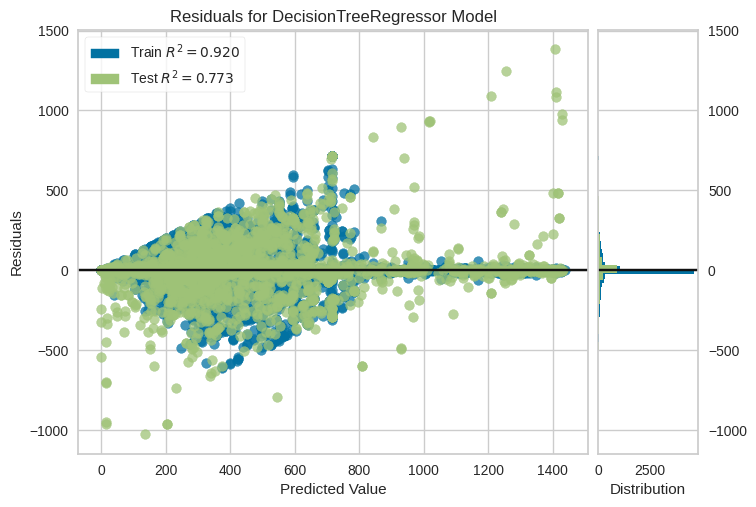

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


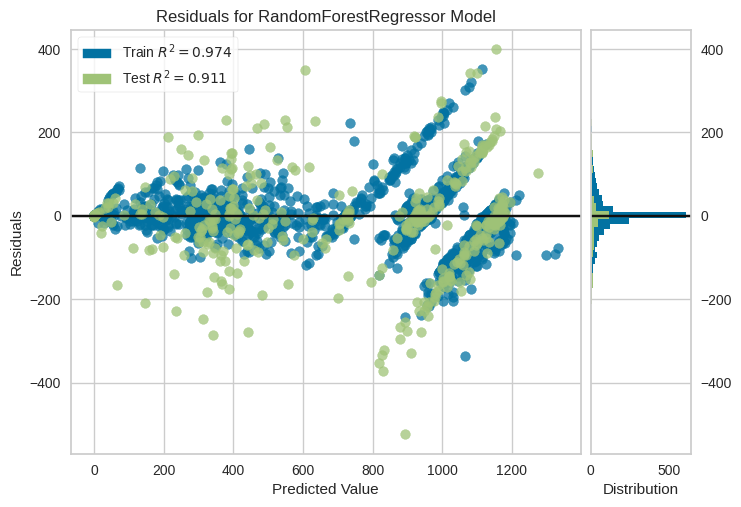

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


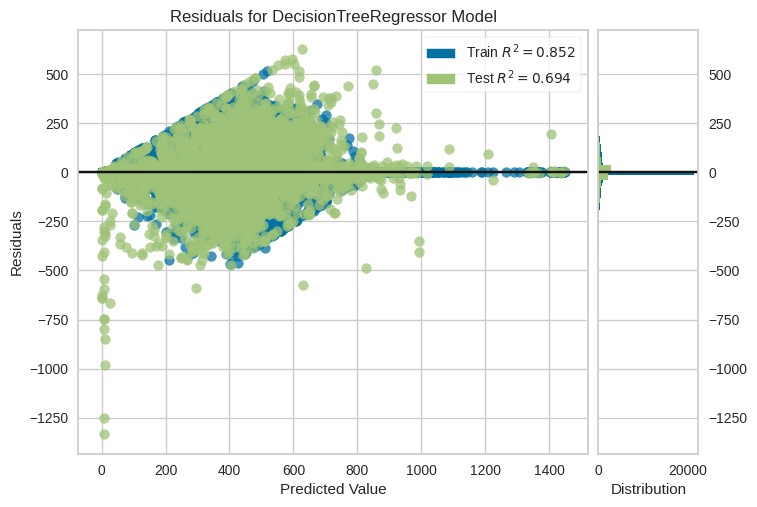

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


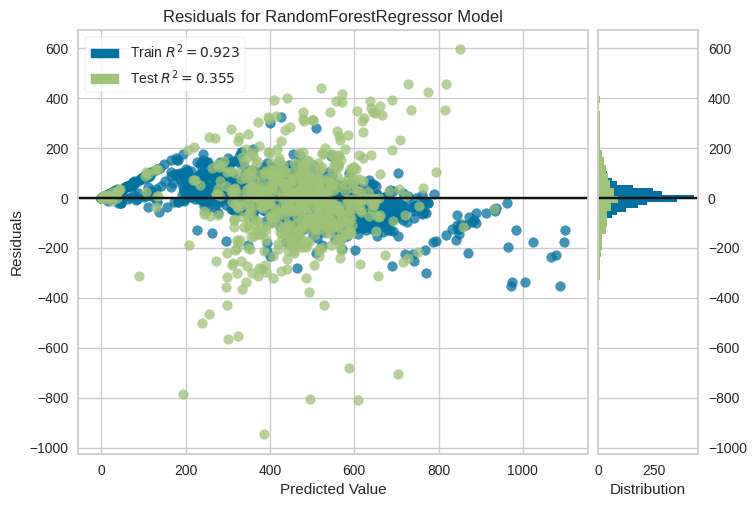

In [ ]:

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import residuals_plot

viz = residuals_plot(model_phase_CD, X_train_CD, y_train_CD, X_test_CD, y_test_CD)
viz = residuals_plot(model_phase_CT, X_train_CT, y_train_CT, X_test_CT, y_test_CT)
viz = residuals_plot(model_phase_NCD, X_train_NCD, y_train_NCD, X_test_NCD, y_test_NCD)
viz = residuals_plot(model_phase_NCT, X_train_NCT, y_train_NCT, X_test_NCT, y_test_NCT)


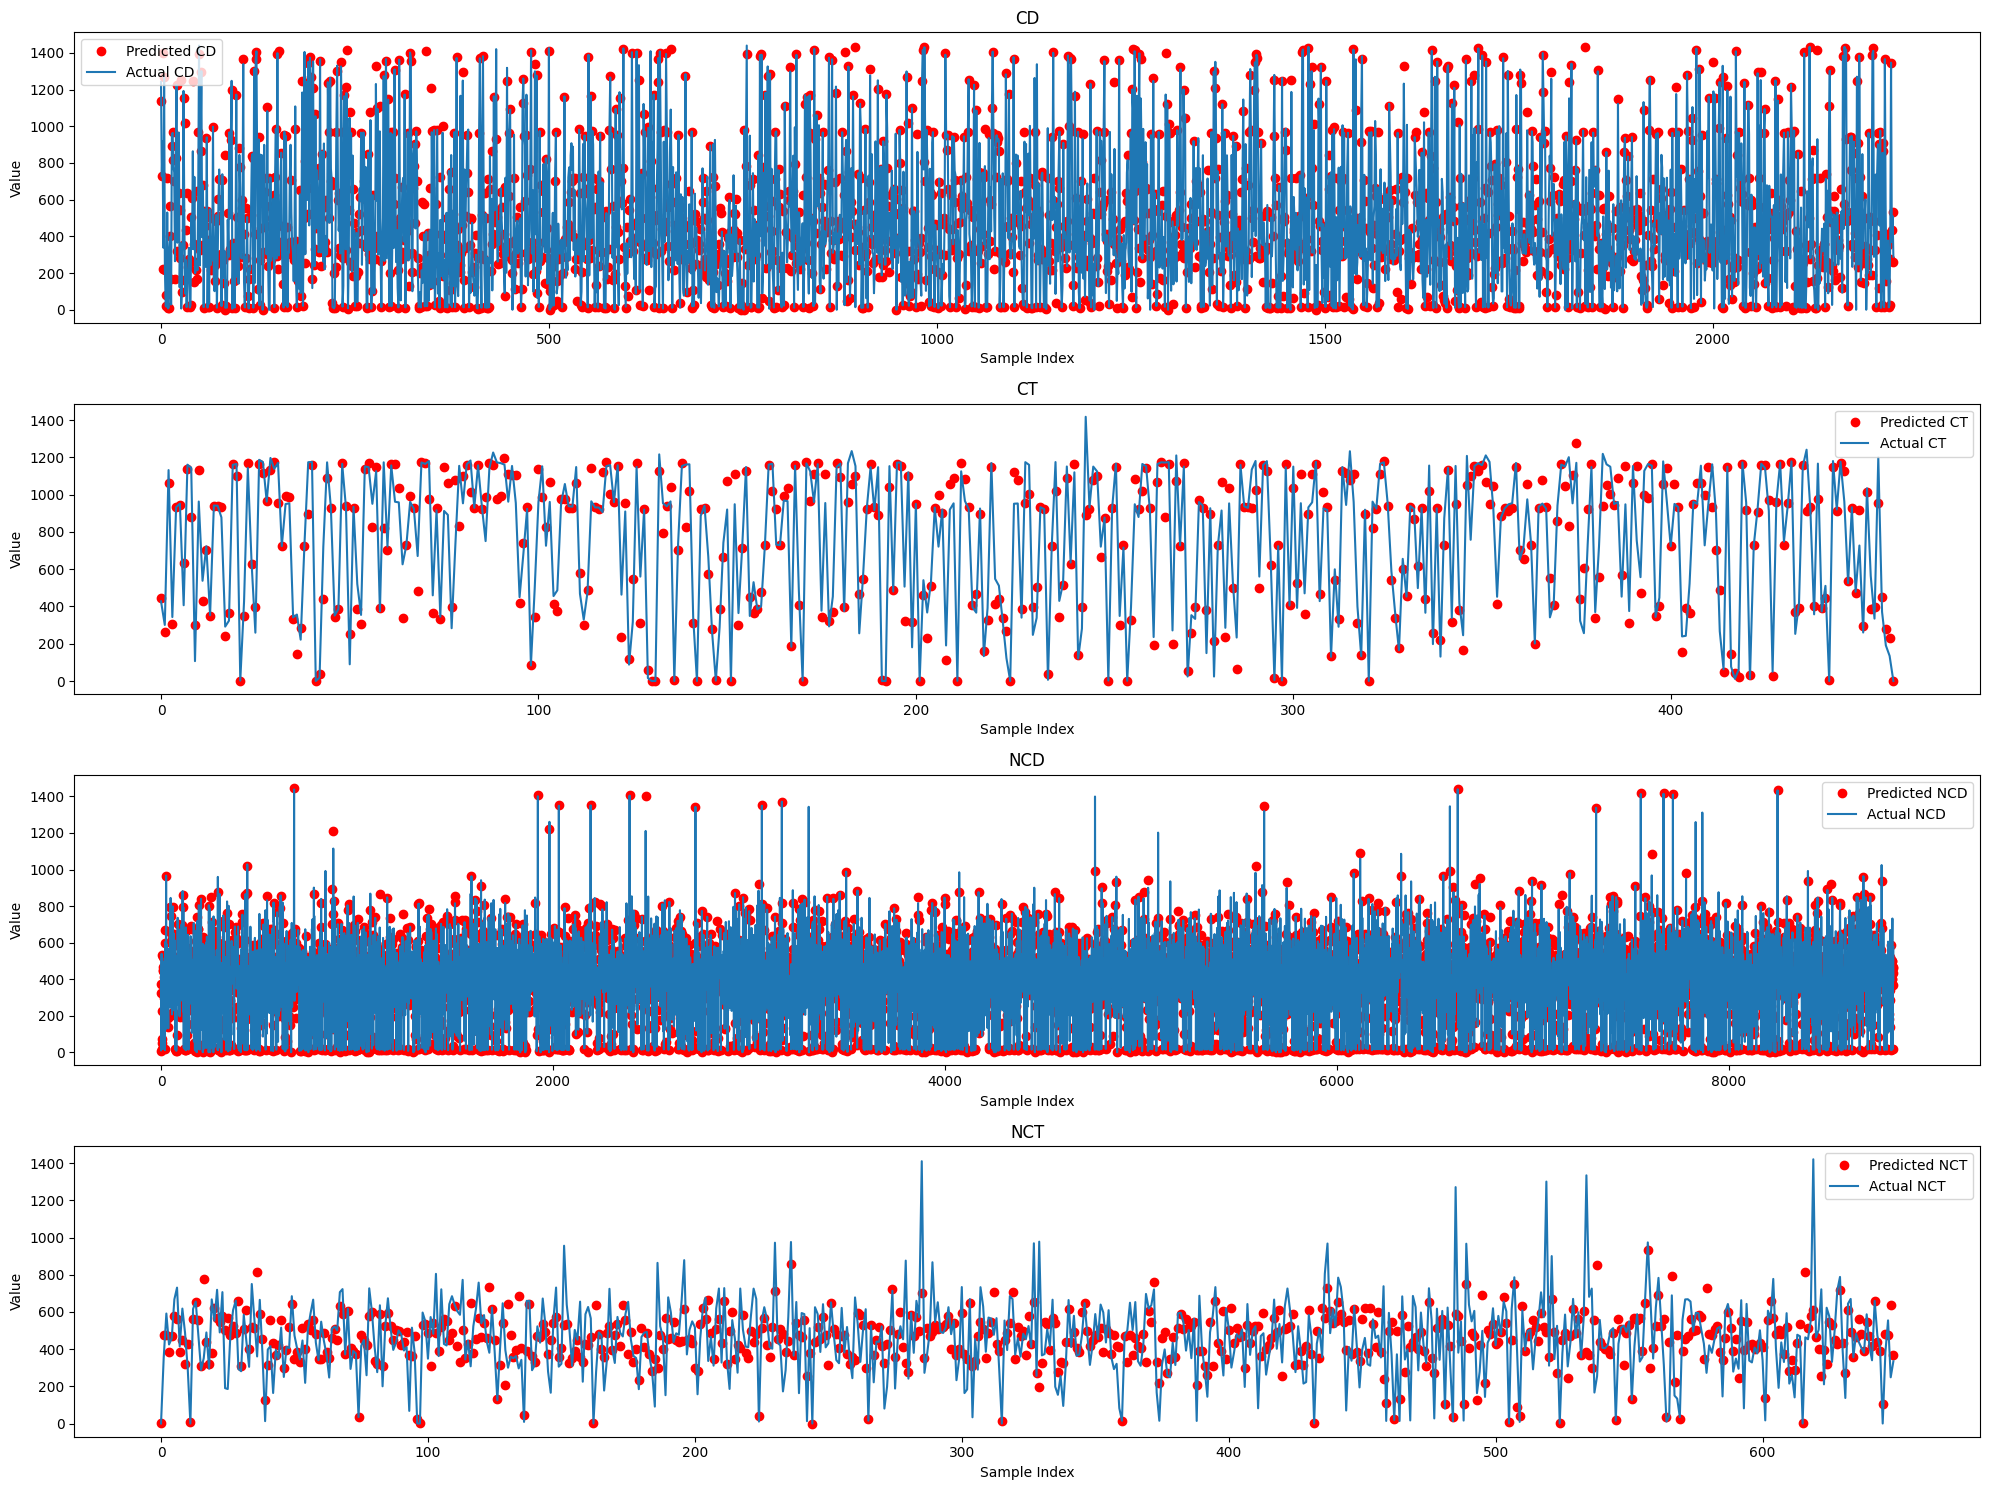

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

for i, (predictions, y_test, label) in enumerate(zip(
        [predictions_CD, predictions_CT, predictions_NCD, predictions_NCT],
        [y_test_CD, y_test_CT, y_test_NCD, y_test_NCT],
        ['CD', 'CT', 'NCD', 'NCT']
    )):

    plt.subplot(4, 1, i+1)

    plt.plot(predictions, 'o',label=f'Predicted {label}' ,color='red')
    plt.plot(y_test.to_numpy(), label=f'Actual {label}')

    plt.title(f'{label}')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()

plt.show()


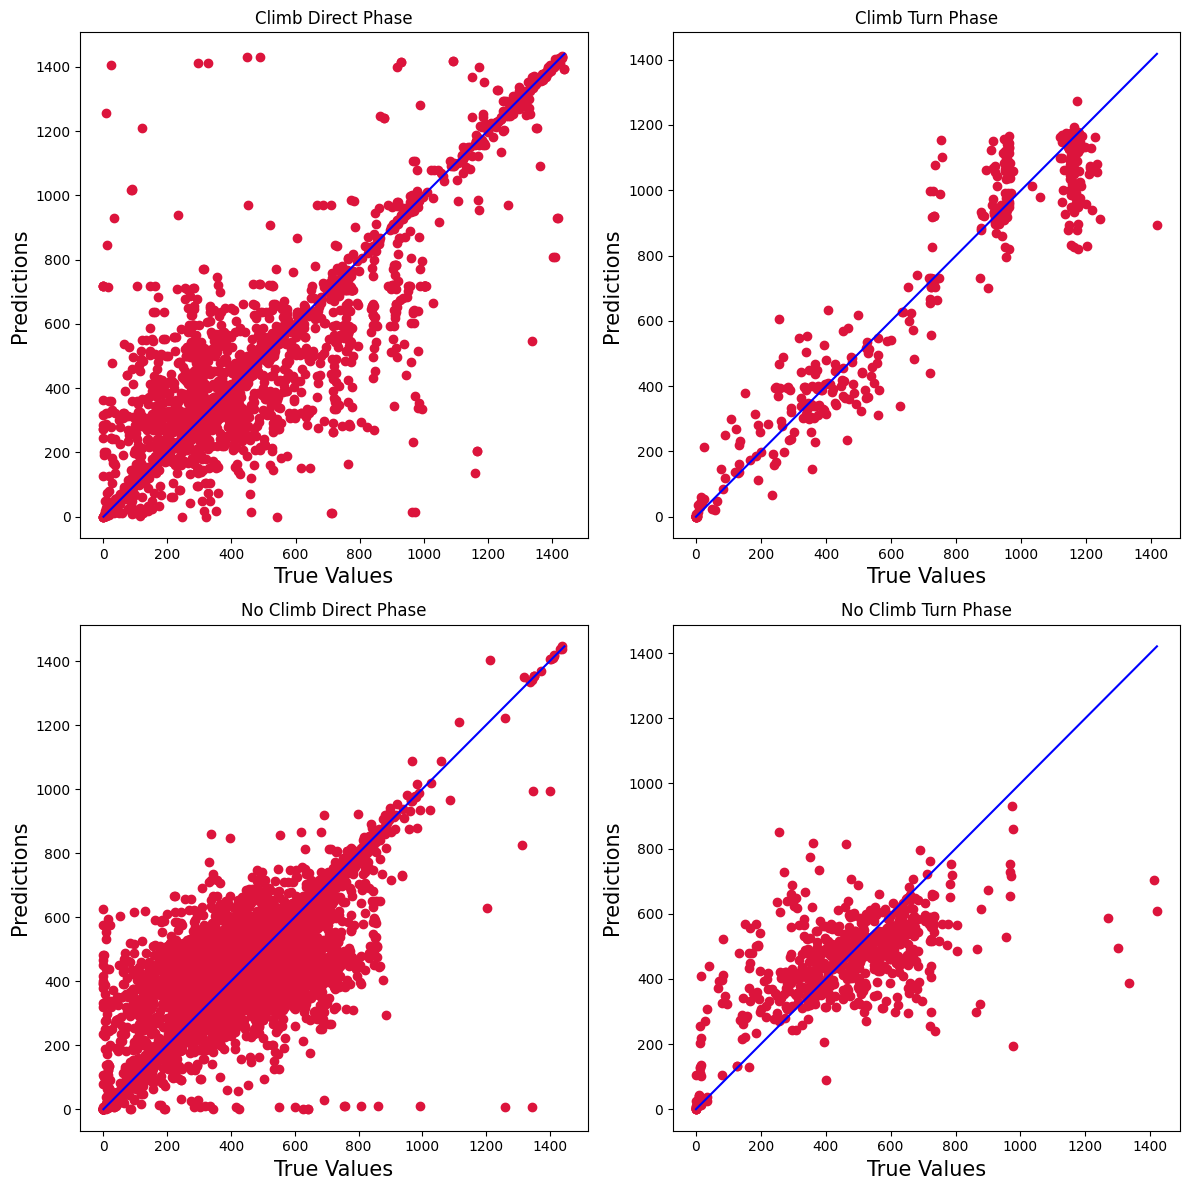

In [ ]:
import matplotlib.pyplot as plt

def plot(actual, predict, ax, title=''):
    ax.scatter(actual, predict, c='crimson')
    p1 = max(max(predict), max(actual))
    p2 = min(min(predict), min(actual))
    ax.plot([p1, p2], [p1, p2], 'b-')
    ax.set_xlabel('True Values', fontsize=15)
    ax.set_ylabel('Predictions', fontsize=15)
    ax.set_title(title)
    ax.axis('equal')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

plot(y_test_CD, predictions_climb_direct, axes[0, 0], 'Climb Direct Phase')
plot(y_test_CT, predictions_climb_turn, axes[0, 1], 'Climb Turn Phase')
plot(y_test_NCD, predictions_no_climb_direct, axes[1, 0], 'No Climb Direct Phase')
plot(y_test_NCT, predictions_no_climb_turn, axes[1, 1], 'No Climb Turn Phase')

plt.tight_layout()
plt.show()


In [ ]:
actual_energy

26058918.647125207

In [ ]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# import pandas as pd


# # Split the data for each phase
# # ...

# # Train each model on its corresponding data
# # ...

# # Predictions for each phase
# predictions_CD = model_phase_CD.predict(X_test_CD)
# predictions_CT = model_phase_CT.predict(X_test_CT)
# predictions_NCD = model_phase_NCD.predict(X_test_NCD)
# predictions_NCT = model_phase_NCT.predict(X_test_NCT)

# # Create StackingRegressor
# estimators = [
#     ('model_phase_CD', model_phase_CD),
#     ('model_phase_CT', model_phase_CT),
#     ('model_phase_NCD', model_phase_NCD),
#     ('model_phase_NCT', model_phase_NCT)
# ]

# stacking_model = StackingRegressor(estimators=estimators, final_estimator=DecisionTreeRegressor(random_state=42))

# # Fit StackingRegressor on the entire dataset
# stacking_model.fit(df[['CTUN_SAs', 'ATT_DesPitch', 'BAT_VoltCurr', 'TECS_dsp', 'ATT_Pitch', 'XKY0_Y1', 'ATT_Roll']],
#                    df['BAT_VoltCurr'])

# # Make predictions using the StackingRegressor
# total_predictions = stacking_model.predict(df[['CTUN_SAs', 'ATT_DesPitch', 'BAT_VoltCurr', 'TECS_dsp', 'ATT_Pitch', 'XKY0_Y1', 'ATT_Roll']])

# # Calculate RMSE
# error = mean_squared_error(df['BAT_VoltCurr'], total_predictions, squared=False)
# print(error)


0.18060276177352766


In [ ]:
stacking_model

StackingRegressor(estimators=[('model_phase_CD',
                               DecisionTreeRegressor(random_state=42)),
                              ('model_phase_CT',
                               RandomForestRegressor(random_state=42)),
                              ('model_phase_NCD',
                               DecisionTreeRegressor(random_state=42)),
                              ('model_phase_NCT',
                               RandomForestRegressor(random_state=42))],
                  final_estimator=DecisionTreeRegressor(random_state=42))

In [ ]:
y_test_NCT.sum(), predictions_no_climb_turn.sum()

(296260.3118723784, 293186.5487840563)

In [ ]:
df = df_filter_mode.fillna(0)
actual_energy = df['BAT_VoltCurr'].sum()

condition_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] > 1)
condition_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] > 1)
condition_no_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] < 1)
condition_no_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] < 1)

df_climb_direct = df[condition_climb_direct].copy()
df_climb_turn = df[condition_climb_turn].copy()
df_no_climb_direct = df[condition_no_climb_direct].copy()
df_no_climb_turn = df[condition_no_climb_turn].copy()

X_CD=df_climb_direct.drop('BAT_VoltCurr', axis=1)
y_CD=df_climb_direct['BAT_VoltCurr']
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(X_CD, y_CD, test_size=0.20, random_state=1)

X_CT=df_climb_turn.drop('BAT_VoltCurr', axis=1)
y_CT=df_climb_turn['BAT_VoltCurr']
X_train_CT, X_test_CT, y_train_CT, y_test_CT = train_test_split(X_CT, y_CT, test_size=0.20, random_state=1)

X_NCD=df_no_climb_direct.drop('BAT_VoltCurr', axis=1)
y_NCD=df_no_climb_direct['BAT_VoltCurr']
X_train_NCD, X_test_NCD, y_train_NCD, y_test_NCD = train_test_split(X_NCD, y_NCD, test_size=0.20, random_state=1)

X_NCT=df_no_climb_turn.drop('BAT_VoltCurr', axis=1)
y_NCT=df_no_climb_turn['BAT_VoltCurr']
X_train_NCT, X_test_NCT, y_train_NCT, y_test_NCT = train_test_split(X_NCT, y_NCT, test_size=0.20, random_state=1)



In [ ]:
total1 = pd.concat([X_test_CD, y_test_CD],axis = 1)
total2 = pd.concat([X_test_CT, y_test_CT],axis = 1)
total3 = pd.concat([X_test_NCD, y_test_NCD],axis = 1)
total4 = pd.concat([X_test_NCT, y_test_NCT],axis = 1)
total = pd.concat([total1, total2 , total3, total4],axis = 0)

In [ ]:
total

,IMU_GyrX,IMU_GyrY,IMU_GyrZ,IMU_AccX,IMU_AccY,IMU_AccZ,IMU_EG,IMU_EA,IMU_T,IMU_GHz,...,QTUN_Sscl,PSCD_TPD,PSCD_PD,PSCD_DVD,PSCD_TVD,PSCD_VD,PSCD_DAD,PSCD_TAD,PSCD_AD,BAT_VoltCurr
841,0.007324,-0.028766,0.030965,1.689741,-0.102702,-8.823708,0,0,53.32085,8030,...,0.0,-67.686274,-69.769104,-0.559097,1.523730,-2.756982,0.034359,21.418980,0.493740,1241.357357
878,-0.099003,-0.105450,-0.001866,0.806220,-0.021464,-9.507814,0,0,64.14101,8027,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,727.719923
479,-0.009028,0.044964,0.076328,0.927184,-0.173810,-9.689764,0,0,53.24512,8030,...,0.0,-59.619203,-62.006500,-0.582862,1.804434,-3.103043,0.036519,24.556279,0.589926,916.548404
6123,0.120059,-0.102886,0.034411,-0.131340,-0.047169,-5.976741,0,0,48.42837,7962,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,338.369743
838,-0.007972,0.012845,0.036921,1.788028,-0.232672,-9.536491,0,0,53.32311,8030,...,0.0,-67.619420,-69.704773,-0.559293,1.526056,-2.759850,0.034377,21.444980,0.494537,1270.651991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14485,0.045478,-0.165476,-0.029844,-1.411551,-0.457901,-10.667230,0,0,46.93239,8031,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3904,-0.099326,-0.031925,0.125771,0.165214,0.024438,-9.795487,0,0,44.90547,8032,...,0.0,-50.652784,-50.742077,-0.048667,0.040626,-0.008844,0.216549,0.459655,0.541113,381.877003
7186,0.016293,0.146370,0.173134,0.643781,-0.080113,-15.794900,0,0,44.58011,8032,...,0.0,-82.995144,-84.185427,-0.896790,0.280511,-1.369634,0.557822,8.860786,0.756535,554.463878
11038,0.183504,0.001058,-0.085414,-0.271508,-0.552789,-8.877269,0,0,48.40498,8031,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,248.503569


In [ ]:
from sklearn.metrics import mean_squared_error

class StackingModel:
    def __init__(self, model_CD, model_CT, model_NCD, model_NCT):
        self.model_CD = model_CD
        self.model_CT = model_CT
        self.model_NCD = model_NCD
        self.model_NCT = model_NCT

    def predict(self, data):
        total_predictions = 0
        predictions_CD= np.zeros((0, 0))
        predictions_CT= np.zeros((0, 0))
        predictions_NCD= np.zeros((0, 0))
        predictions_NCT = np.zeros((0, 0))

        condition_CD = (data['ATT_Roll'] <= 10) & (data['TECS_dh'] > 1)
        condition_CT = (data['ATT_Roll'] > 10) & (data['TECS_dh'] > 1)
        condition_NCD = (data['ATT_Roll'] <= 10) & (data['TECS_dh'] < 1)
        condition_NCT = (data['ATT_Roll'] > 10) & (data['TECS_dh'] < 1)

        if condition_CD.any():
            temp_CD = data[condition_CD]
            predictions_CD = self.model_CD.predict(temp_CD[['CTUN_As', 'ATT_DesPitch']])
            error_CD = mean_squared_error(temp_CD['BAT_VoltCurr'], predictions_CD, squared=False)
            print("Mean Squared Error for CD:", error_CD)

        if condition_CT.any():
            temp_CT = data[condition_CT]
            predictions_CT = self.model_CT.predict(temp_CT[['TECS_dsp', 'ATT_Pitch']])
            error_CT = mean_squared_error(temp_CT['BAT_VoltCurr'], predictions_CT, squared=False)
            print("Mean Squared Error for CT:", error_CT)

        if condition_NCD.any():
            temp_NCD = data[condition_NCD]
            predictions_NCD = self.model_NCD.predict(temp_NCD[['TECS_spdem', 'ATT_DesPitch', 'AOA_SSA']])
            error_NCD = mean_squared_error(temp_NCD['BAT_VoltCurr'], predictions_NCD, squared=False)
            print("Mean Squared Error for NCD:", error_NCD)

        if condition_NCT.any():
            temp_NCT = data[condition_NCT]
            predictions_NCT = self.model_NCT.predict(temp_NCT[['ATT_Roll', 'ATT_DesPitch']])
            error_NCT = mean_squared_error(temp_NCT['BAT_VoltCurr'], predictions_NCT, squared=False)
            print("Mean Squared Error for NCT:", error_NCT)

        # x = temp_CD['BAT_VoltCurr'].sum() + temp_CT['BAT_VoltCurr'].sum() + temp_NCD['BAT_VoltCurr'].sum() + temp_NCT['BAT_VoltCurr'].sum()

        total_predictions = predictions_CD.sum() + predictions_CT.sum() + predictions_NCD.sum() + predictions_NCT.sum()
        print("total_predictions:", total_predictions)
        # return total_predictions


# # สร้าง StackingModel ด้วยโมเดลย่อย 4 ตัว
stacking_model = StackingModel(model_phase_CD, model_phase_CT, model_phase_NCD, model_phase_NCT)

# total_predictions  = stacking_model.predict(total)
# print("total_predictions:", total_predictions)

#sobol

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


{'S1': array([0.28982955, 0.51875362]), 'S1_conf': array([0.01346872, 0.01815844]), 'ST': array([0.4826863 , 0.70924354]), 'ST_conf': array([0.01148822, 0.01531391])}


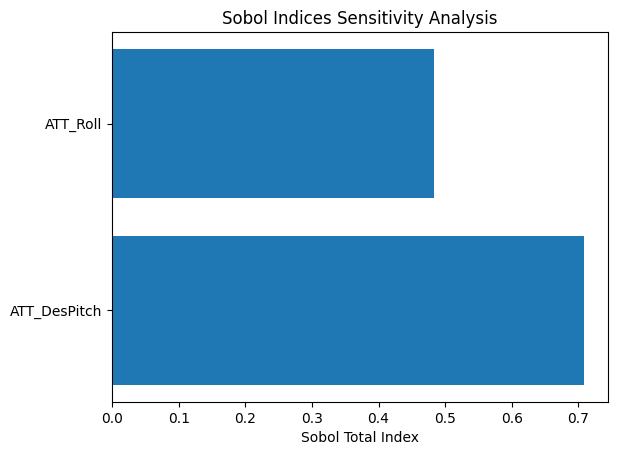

Total Sobol Indices for ['ATT_Roll', 'ATT_DesPitch']: 1.1919298413844746


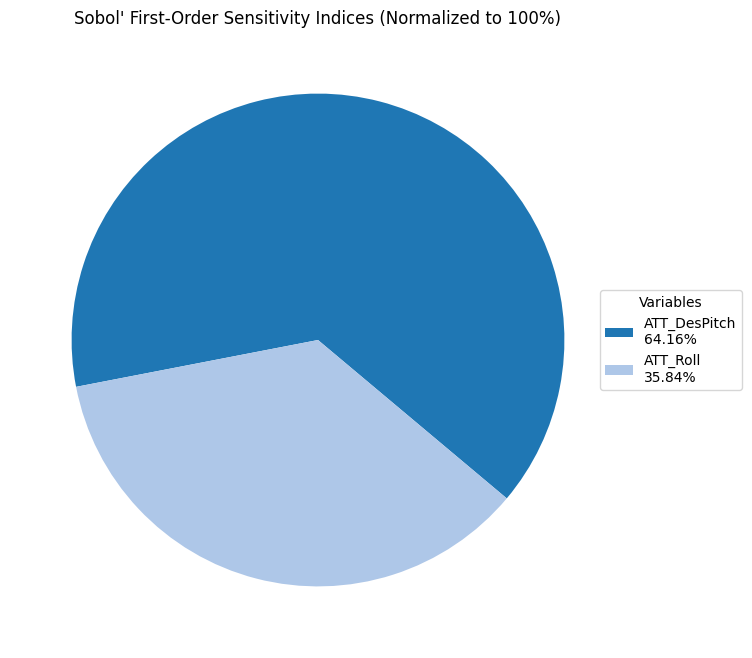

In [ ]:
# !pip install SALib

from SALib.analyze import sobol as sobol_analyze
from SALib.test_functions import Ishigami
from SALib.sample import sobol
import sklearn
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axis as ax
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


# X = total.drop(columns=["BAT_VoltCurr"])
# y = df["BAT_VoltCurr"]
X = X_test_NCT
y = y_test_NCT

model = model_phase_NCT

problem = {
    'num_vars': len(X.columns),
    'names': X.columns.tolist(),
    'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(len(X.columns))]
}


N = 16384 # number of samples
# Generate samples
X_sobol = sobol.sample(problem, N, calc_second_order=False)
y_sobol = model.predict(X_sobol)

# y_sobol = model.predict(X.iloc[:18000])
# print(len(y_sobol))

Si = sobol_analyze.analyze(problem, y_sobol, calc_second_order=False )
print(Si)

fig, ax = plt.subplots()
indices = Si['ST']
names = problem['names']
y_pos = np.arange(len(names))
ax.barh(y_pos, indices)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel('Sobol Total Index')
ax.set_title('Sobol Indices Sensitivity Analysis')
plt.show()

# Print the total Sobol Indices
print(f"Total Sobol Indices for {list(X.columns)}: {Si['ST'].sum()}")


s1_values = Si['S1']
variable_names = problem['names']
total_s1 = sum(s1_values)

s1_values_normalized = [s1 / total_s1 * 100 for s1 in s1_values]

sensitivity_data = list(zip(variable_names, s1_values_normalized))
sensitivity_data = sorted(sensitivity_data, key=lambda item: item[1], reverse=True)
variable_names, s1_values_normalized = zip(*sensitivity_data)

with plt.style.context({"axes.prop_cycle" : plt.cycler("color", plt.cm.tab20.colors)}):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(s1_values_normalized, labels=None, autopct='', wedgeprops=None, startangle=-40)

labels = [f'{variable_names[i]}\n{s1_values_normalized[i]:.2f}%' for i in range(len(variable_names))]
ax.legend(wedges, labels, title="Variables", loc="center right", bbox_to_anchor=(1.2, 0.5))
ax.set_title("Sobol' First-Order Sensitivity Indices (Normalized to 100%)")

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Total Sobol Indices for ['CTUN_SAs', 'ATT_DesPitch']: 1.5371414756394808


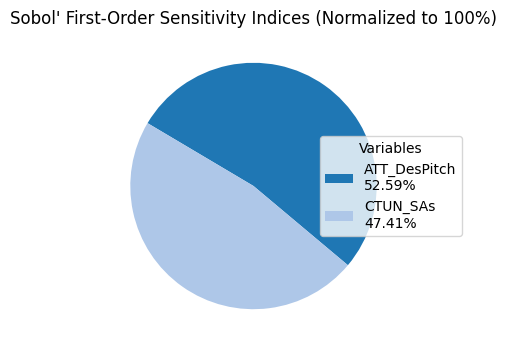

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Total Sobol Indices for ['TECS_dsp', 'ATT_Pitch']: 1.0869752495572726


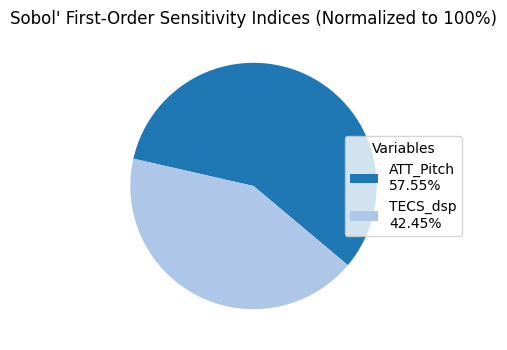

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Total Sobol Indices for ['TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1']: 1.595632972388957


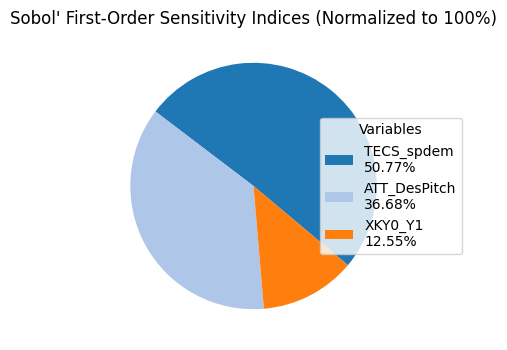

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Total Sobol Indices for ['ATT_Roll', 'ATT_DesPitch']: 1.191253600339103


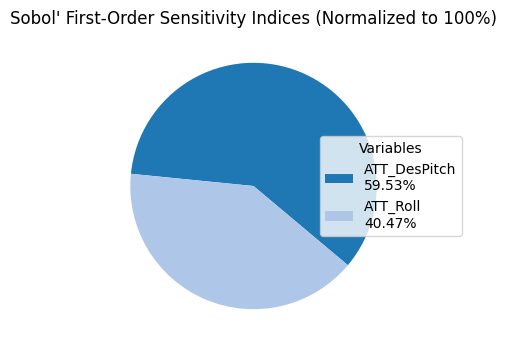

In [ ]:
from SALib.analyze import sobol as sobol_analyze
from SALib.sample import sobol
import matplotlib.pyplot as plt
import numpy as np

def run_sobol_analysis(model, X, y):
    problem = {
        'num_vars': len(X.columns),
        'names': X.columns.tolist(),
        'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(len(X.columns))]
    }

    N = 16384  # number of samples
    # Generate samples
    X_sobol = sobol.sample(problem, N, calc_second_order=False)
    y_sobol = model.predict(X_sobol)

    Si = sobol_analyze.analyze(problem, y_sobol, calc_second_order=False)

    # Plot bar chart for total Sobol Indices
    # fig, ax = plt.subplots()
    # indices = Si['ST']
    # names = problem['names']
    # y_pos = np.arange(len(names))
    # ax.barh(y_pos, indices)
    # ax.set_yticks(y_pos)
    # ax.set_yticklabels(names)
    # ax.invert_yaxis()
    # ax.set_xlabel('Sobol Total Index')
    # ax.set_title('Sobol Indices Sensitivity Analysis')
    # plt.show()

    # Print the total Sobol Indices
    print(f"Total Sobol Indices for {list(X.columns)}: {Si['ST'].sum()}")

    # Plot pie chart for normalized first-order Sobol Indices
    s1_values = Si['ST']
    variable_names = problem['names']
    total_s1 = sum(s1_values)

    s1_values_normalized = [s1 / total_s1 * 100 for s1 in s1_values]

    sensitivity_data = list(zip(variable_names, s1_values_normalized))
    sensitivity_data = sorted(sensitivity_data, key=lambda item: item[1], reverse=True)
    variable_names, s1_values_normalized = zip(*sensitivity_data)

    with plt.style.context({"axes.prop_cycle": plt.cycler("color", plt.cm.tab20.colors)}):
        fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))
        wedges, texts, autotexts = ax.pie(s1_values_normalized, labels=None, autopct='', wedgeprops=None,
                                          startangle=-40)

    labels = [f'{variable_names[i]}\n{s1_values_normalized[i]:.2f}%' for i in range(len(variable_names))]
    ax.legend(wedges, labels, title="Variables", loc="center right", bbox_to_anchor=(1.2, 0.5))
    ax.set_title("Sobol' First-Order Sensitivity Indices (Normalized to 100%)")
    plt.show()


run_sobol_analysis(model_phase_CD, X_test_CD, y_test_CD)
run_sobol_analysis(model_phase_CT, X_test_CT, y_test_CT)
run_sobol_analysis(model_phase_NCD, X_test_NCD, y_test_NCD)
run_sobol_analysis(model_phase_NCT, X_test_NCT, y_test_NCT)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Total Sobol Indices for ['CTUN_SAs', 'ATT_DesPitch']: 1.5368779715087921


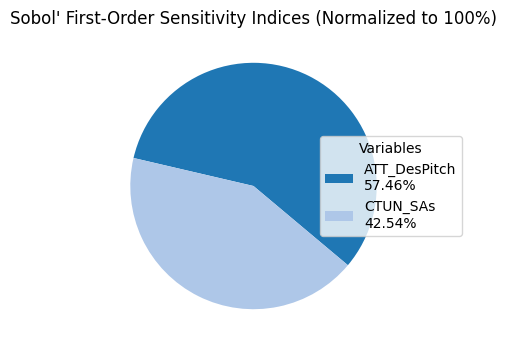

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Total Sobol Indices for ['TECS_dsp', 'ATT_Pitch']: 1.0888999403642852


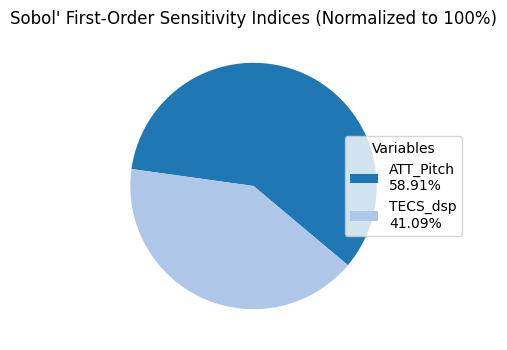

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Total Sobol Indices for ['TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1']: 1.6278267836848221


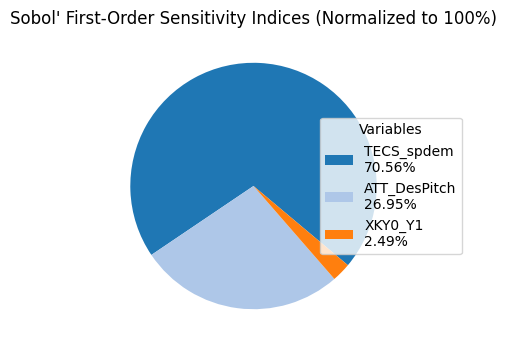

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Total Sobol Indices for ['ATT_Roll', 'ATT_DesPitch']: 1.1901023643225128


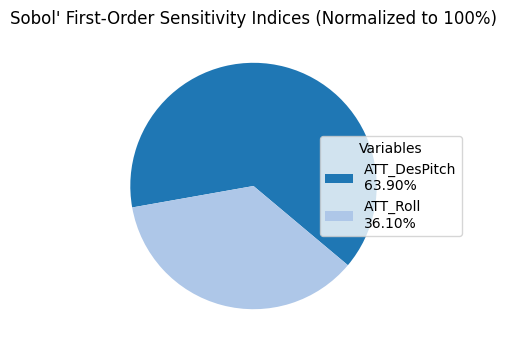

In [ ]:
from SALib.analyze import sobol as sobol_analyze
from SALib.sample import sobol
import matplotlib.pyplot as plt
import numpy as np

def run_sobol_analysis(model, X, y):
    problem = {
        'num_vars': len(X.columns),
        'names': X.columns.tolist(),
        'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(len(X.columns))]
    }

    N = 16384  # number of samples
    # Generate samples
    X_sobol = sobol.sample(problem, N, calc_second_order=False)
    y_sobol = model.predict(X_sobol)

    Si = sobol_analyze.analyze(problem, y_sobol, calc_second_order=False)

    # Plot bar chart for total Sobol Indices
    # fig, ax = plt.subplots()
    # indices = Si['ST']
    # names = problem['names']
    # y_pos = np.arange(len(names))
    # ax.barh(y_pos, indices)
    # ax.set_yticks(y_pos)
    # ax.set_yticklabels(names)
    # ax.invert_yaxis()
    # ax.set_xlabel('Sobol Total Index')
    # ax.set_title('Sobol Indices Sensitivity Analysis')
    # plt.show()

    # Print the total Sobol Indices
    print(f"Total Sobol Indices for {list(X.columns)}: {Si['ST'].sum()}")

    # Plot pie chart for normalized first-order Sobol Indices
    s1_values = Si['S1']
    variable_names = problem['names']
    total_s1 = sum(s1_values)

    s1_values_normalized = [s1 / total_s1 * 100 for s1 in s1_values]

    sensitivity_data = list(zip(variable_names, s1_values_normalized))
    sensitivity_data = sorted(sensitivity_data, key=lambda item: item[1], reverse=True)
    variable_names, s1_values_normalized = zip(*sensitivity_data)

    with plt.style.context({"axes.prop_cycle": plt.cycler("color", plt.cm.tab20.colors)}):
        fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))
        wedges, texts, autotexts = ax.pie(s1_values_normalized, labels=None, autopct='', wedgeprops=None,
                                          startangle=-40)

    labels = [f'{variable_names[i]}\n{s1_values_normalized[i]:.2f}%' for i in range(len(variable_names))]
    ax.legend(wedges, labels, title="Variables", loc="center right", bbox_to_anchor=(1.2, 0.5))
    ax.set_title("Sobol' First-Order Sensitivity Indices (Normalized to 100%)")
    plt.show()

# Assuming you have models named model_phase_CD, model_phase_CT, model_phase_NCD, model_phase_NCT
# and corresponding test datasets X_test_CD, y_test_CD, X_test_CT, y_test_CT, X_test_NCD, y_test_NCD, X_test_NCT, y_test_NCT

run_sobol_analysis(model_phase_CD, X_test_CD, y_test_CD)
run_sobol_analysis(model_phase_CT, X_test_CT, y_test_CT)
run_sobol_analysis(model_phase_NCD, X_test_NCD, y_test_NCD)
run_sobol_analysis(model_phase_NCT, X_test_NCT, y_test_NCT)


In [ ]:
# Assuming you have y_test_CD, y_test_CT, y_test_NCD, y_test_NCT
total_energy_CD = y_test_CD.sum()
total_energy_CT = y_test_CT.sum()
total_energy_NCD = y_test_NCD.sum()
total_energy_NCT = y_test_NCT.sum()

proportion_CD = total_energy_CD / (total_energy_CD + total_energy_CT + total_energy_NCD + total_energy_NCT)
proportion_CT = total_energy_CT / (total_energy_CD + total_energy_CT + total_energy_NCD + total_energy_NCT)
proportion_NCD = total_energy_NCD / (total_energy_CD + total_energy_CT + total_energy_NCD + total_energy_NCT)
proportion_NCT = total_energy_NCT / (total_energy_CD + total_energy_CT + total_energy_NCD + total_energy_NCT)

print(f"Proportion of Total Energy for CD: {proportion_CD:.2%}")
print(f"Proportion of Total Energy for CT: {proportion_CT:.2%}")
print(f"Proportion of Total Energy for NCD: {proportion_NCD:.2%}")
print(f"Proportion of Total Energy for NCT: {proportion_NCT:.2%}")


Proportion of Total Energy for CD: 21.03%
Proportion of Total Energy for CT: 6.61%
Proportion of Total Energy for NCD: 66.68%
Proportion of Total Energy for NCT: 5.68%


In [ ]:
sobol_indices_list

[array([0.73279661, 0.80419929]),
 array([0.46162816, 0.62532177]),
 array([0.8090385 , 0.58456317, 0.20649376]),
 array([0.48204393, 0.709657  ])]

In [ ]:
import pandas as pd

def run_sobol_analysis(model, X, y):
    problem = {
        'num_vars': len(X.columns),
        'names': X.columns.tolist(),
        'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(len(X.columns))]
    }

    N = 16384  # number of samples
    # Generate samples
    X_sobol = sobol.sample(problem, N, calc_second_order=False)
    y_sobol = model.predict(X_sobol)

    Si = sobol_analyze.analyze(problem, y_sobol, calc_second_order=False)

    return Si


models = [model_phase_CD, model_phase_CT, model_phase_NCD, model_phase_NCT]
datasets = [(X_test_CD, y_test_CD), (X_test_CT, y_test_CT), (X_test_NCD, y_test_NCD), (X_test_NCT, y_test_NCT)]

total_energy = sum([dataset[1].sum() for dataset in datasets])

sobol_results = [run_sobol_analysis(models[i], datasets[i][0], datasets[i][1]) for i in range(4)]

model_names = ['model_phase_CD', 'model_phase_CT', 'model_phase_NCD', 'model_phase_NCT']
variable_names_list = [datasets[i][0].columns.tolist() for i in range(4)]
flattened_list = [item for sublist in variable_names_list for item in sublist]
df_list = []

for i, result in enumerate(sobol_results):
    sobol_indices = result['ST']
    total_energy = datasets[i][1].sum()
    for j, sobol_index in enumerate(sobol_indices):
        df_list.append({
            'model': model_names[i],
            'variable': variable_names_list[i][j],
            'ST_ratio': (sobol_index / sobol_indices.sum()) * total_energy
        })

df = pd.DataFrame(df_list)
df = df.pivot_table('ST_ratio', ['model', 'variable'])



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,model,variable,ST_ratio
0,model_phase_CD,CTUN_SAs,5.281625e+05
1,model_phase_CD,ATT_DesPitch,5.691762e+05
2,model_phase_CT,TECS_dsp,1.466894e+05
3,model_phase_CT,ATT_Pitch,1.982013e+05
4,model_phase_NCD,TECS_spdem,1.760821e+06
5,model_phase_NCD,ATT_DesPitch,1.280416e+06
6,model_phase_NCD,XKY0_Y1,4.373376e+05
7,model_phase_NCT,ATT_Roll,1.202340e+05
8,model_phase_NCT,ATT_DesPitch,1.760264e+05


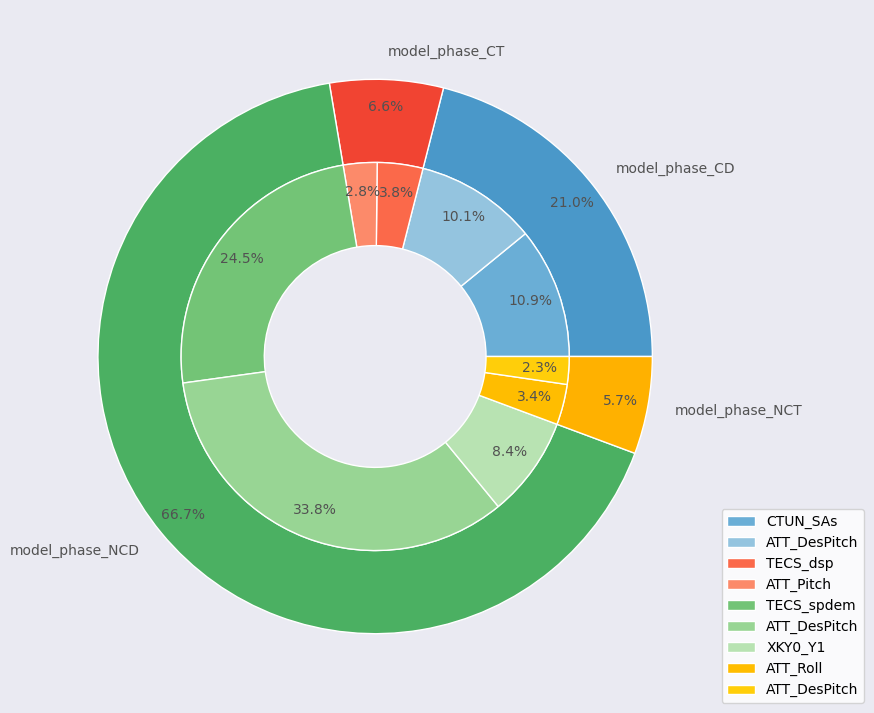

In [ ]:
facecolor = '#eaeaf2'
font_color = '#525252'
hfont = {'fontname':'Calibri'}
labels = ["model_phase_CD", "model_phase_CT", "model_phase_NCD", "model_phase_NCT"]
size = 0.3
vals = df['ST_ratio']
group_sum = df.groupby('model')['ST_ratio'].sum()

fig, ax = plt.subplots(figsize=(15,9), facecolor=facecolor)
a,b,c,d = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens ,plt.cm.Wistia ]

outer_colors = [a(.6), b(.6), c(.6), d(.6)]
inner_colors = [a(.5), a(.4),
                b(.5), b(.4),
                c(.5), c(.4), c(.3),
                d(.5), d(.4),]

ax.pie(group_sum,
       radius=1,
       colors=outer_colors,
       labels=labels,
       autopct='%1.1f%%',
       textprops={'color':font_color},
       wedgeprops=dict(width=size, edgecolor='w'),
       pctdistance=0.9)

wedges, texts, autotexts  = ax.pie(vals,
       radius=1-size, # size=0.3
       colors=inner_colors,
      #  labels=flattened_list,
       autopct='%1.1f%%',  # ใส่ autopct ในนี้
       textprops={'color':font_color},
       wedgeprops=dict(width=size, edgecolor='w'),
       pctdistance=0.85)  # กำหนดระยะห่างระหว่าง Label กับ Pie Chart

ax.legend(wedges, flattened_list, loc=(0.5, 0.5), bbox_to_anchor=(1, 0))


In [ ]:
file = 'drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/test_sobol/00000062.csv'
df = pd.read_csv(file)
#for 4.1.5
columns_to_remove = df.filter(regex=r'\[.*[1-9].*\]').columns #ลบที่ไม่ใช่ [0]
df.drop(columns=columns_to_remove, inplace=True)

df.rename(columns=lambda x: x.replace(r'[0]', ''), inplace=True)

#for 4.0.8
columns_to_remove = df.filter(regex=r'^IMU(\d+)').columns
df.drop(columns=columns_to_remove, inplace=True)
df.rename(columns=lambda x: re.sub(r'^NKF(\d+)', r'XKF\1', x), inplace=True)
df.rename(columns=lambda x: re.sub(r'CTUN_Aspd', r'CTUN_As', x), inplace=True)


df = df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

data = df["ATT_Roll"].to_numpy()

In [ ]:
df

,IMU_GyrX,IMU_GyrY,IMU_GyrZ,IMU_AccX,IMU_AccY,IMU_AccZ,IMU_EG,IMU_EA,IMU_T,IMU_GHz,...,NKT3_EKFMax,NKT3_AngMin,NKT3_AngMax,NKT3_VMin,NKT3_VMax,TSYN_RTT,LAND_slope,LAND_slopeInit,LAND_altO,BAT_VoltCurr
0,-0.000185,0.000543,-0.000299,0.112513,0.023062,-9.784098,0,0,47.69921,8031,...,0.010357,0.007056,0.023816,0.007056,0.023816,203734.0,0.0,0.0,0.0,0.0
1,0.000970,0.000671,-0.000285,0.112165,0.020253,-9.789964,0,0,47.69788,8031,...,0.010357,0.007056,0.023816,0.007056,0.023816,203734.0,0.0,0.0,0.0,0.0
2,-0.000150,0.000908,-0.000382,0.114802,0.030695,-9.777178,0,0,47.69518,8031,...,0.010357,0.007056,0.023816,0.007056,0.023816,203734.0,0.0,0.0,0.0,0.0
3,0.000523,-0.000745,-0.000174,0.110136,0.014851,-9.791104,0,0,47.69520,8031,...,0.010357,0.007056,0.023816,0.007056,0.023816,203734.0,0.0,0.0,0.0,0.0
4,0.000370,0.000389,-0.000516,0.118804,0.017853,-9.786855,0,0,47.69408,8031,...,0.010357,0.007056,0.023816,0.007056,0.023816,203734.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39873,-0.000802,-0.000182,-0.000451,0.047157,0.160389,-9.769445,0,0,47.92410,8031,...,0.010017,0.007939,0.010586,0.007939,0.010586,376005.0,0.0,0.0,0.0,0.0
39874,-0.000049,0.000269,-0.000154,0.047140,0.159249,-9.780130,0,0,47.92769,8031,...,0.010017,0.007939,0.010586,0.007939,0.010586,376005.0,0.0,0.0,0.0,0.0
39875,-0.000299,0.000378,0.000366,0.042366,0.161593,-9.784821,0,0,47.93166,8031,...,0.010017,0.007939,0.010586,0.007939,0.010586,376005.0,0.0,0.0,0.0,0.0
39876,-0.000338,-0.000160,0.000356,0.046127,0.154210,-9.772449,0,0,47.93193,8031,...,0.010017,0.007939,0.010586,0.007939,0.010586,376005.0,0.0,0.0,0.0,0.0


In [ ]:
condition_climb_direct = (df['ATT_Roll'].abs() <= 10) & (df['TECS_dh'] > 1)
condition_climb_turn = (df['ATT_Roll'].abs() > 10) & (df['TECS_dh'] > 1)
condition_no_climb_direct = (df['ATT_Roll'].abs() <= 10) & (df['TECS_dh'] < 1)
condition_no_climb_turn = (df['ATT_Roll'].abs() > 10) & (df['TECS_dh'] < 1)

df_climb_direct = df[condition_climb_direct].copy()
df_climb_turn = df[condition_climb_turn].copy()
df_no_climb_direct = df[condition_no_climb_direct].copy()
df_no_climb_turn = df[condition_no_climb_turn].copy()

print("df_climb_direct shape:", df_climb_direct.shape)
print("df_climb_turn shape:", df_climb_turn.shape)
print("df_no_climb_direct shape:", df_no_climb_direct.shape)
print("df_no_climb_turn shape:", df_no_climb_turn.shape)

df_climb_direct shape: (612, 523)
df_climb_turn shape: (2251, 523)
df_no_climb_direct shape: (30845, 523)
df_no_climb_turn shape: (6170, 523)


In [ ]:
data = df["BAT_VoltCurr"].to_numpy()

2024-01-10 15:07:42.000 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=4.2e-05)
2024-01-10 15:07:42.431 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted loguniform distribution with error=0.000115)
2024-01-10 15:07:42.462 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1.6e-05)
2024-01-10 15:07:42.826 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted truncnorm distribution with error=1.6e-05)
2024-01-10 15:07:42.902 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=1.7e-05)
2024-01-10 15:07:43.166 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=2.2e-05)


{'norm': {'loc': 479.70260444974656, 'scale': 305.2512520655004}}

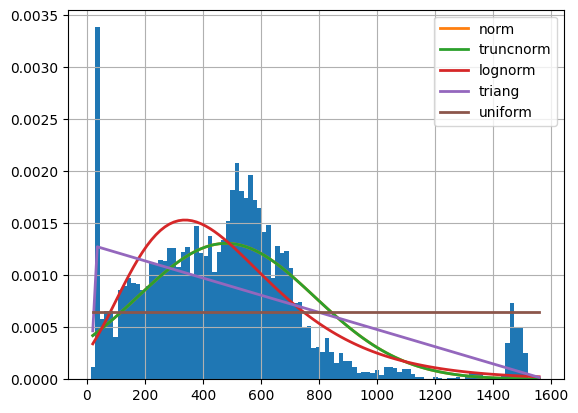

In [ ]:
# !pip install fitter
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

# mu, sigma = 0, 0.1 # mean and standard deviation
# data = np.random.normal(mu, sigma, 10000)
# f = Fitter(data,distributions= get_common_distributions())
f = Fitter(data,distributions= ['uniform', 'loguniform' , 'triang', 'norm' , 'truncnorm' , 'lognorm'])
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')


#test model new data

In [ ]:
file = 'drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/test_sobol/00000062.csv'
df = pd.read_csv(file)
#for 4.1.5
columns_to_remove = df.filter(regex=r'\[.*[1-9].*\]').columns #ลบที่ไม่ใช่ [0]
df.drop(columns=columns_to_remove, inplace=True)

df.rename(columns=lambda x: x.replace(r'[0]', ''), inplace=True)

#for 4.0.8
columns_to_remove = df.filter(regex=r'^IMU(\d+)').columns
df.drop(columns=columns_to_remove, inplace=True)
df.rename(columns=lambda x: re.sub(r'^NKF(\d+)', r'XKF\1', x), inplace=True)
df.rename(columns=lambda x: re.sub(r'CTUN_Aspd', r'CTUN_As', x), inplace=True)


df = df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)


In [ ]:
total_predictions  = stacking_model.predict(df)
total_predictions

Mean Squared Error for CD: 474.6418170912844


KeyError: "['XKY0_Y1'] not in index"

In [ ]:
condition_climb_direct = (df['ATT_Roll'].abs() <= 10) & (df['TECS_dh'] > 1)
condition_climb_turn = (df['ATT_Roll'].abs() > 10) & (df['TECS_dh'] > 1)
condition_no_climb_direct = (df['ATT_Roll'].abs() <= 10) & (df['TECS_dh'] < 1)
condition_no_climb_turn = (df['ATT_Roll'].abs() > 10) & (df['TECS_dh'] < 1)

df_climb_direct = df[condition_climb_direct].copy()
df_climb_turn = df[condition_climb_turn].copy()
df_no_climb_direct = df[condition_no_climb_direct].copy()
df_no_climb_turn = df[condition_no_climb_turn].copy()

column_climb_direct = ['CTUN_As', 'ATT_DesPitch', 'BAT_VoltCurr']
column_climb_turn = ['TECS_dsp', 'ATT_Pitch' , 'BAT_VoltCurr']
column_no_climb_direct = ['TECS_spdem', 'ATT_DesPitch', 'AOA_SSA' , 'BAT_VoltCurr']
column_no_climb_turn = ['ATT_Roll', 'ATT_DesPitch' , 'BAT_VoltCurr']

df_climb_direct = df_climb_direct[column_climb_direct].copy()
X_test_CD=df_climb_direct.drop('BAT_VoltCurr', axis=1)
y_test_CD=df_climb_direct['BAT_VoltCurr']
# X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(X_CD, y_CD, test_size=0.20, random_state=1)

df_climb_turn = df_climb_turn[column_climb_turn].copy()
X_test_CT=df_climb_turn.drop('BAT_VoltCurr', axis=1)
y_test_CT=df_climb_turn['BAT_VoltCurr']
# X_train_CT, X_test_CT, y_train_CT, y_test_CT = train_test_split(X_CT, y_CT, test_size=0.20, random_state=1)

df_no_climb_direct = df_no_climb_direct[column_no_climb_direct].copy()
X_test_NCD=df_no_climb_direct.drop('BAT_VoltCurr', axis=1)
y_test_NCD=df_no_climb_direct['BAT_VoltCurr']
# X_train_NCD, X_test_NCD, y_train_NCD, y_test_NCD = train_test_split(X_NCD, y_NCD, test_size=0.20, random_state=1)

df_no_climb_turn = df_no_climb_turn[column_no_climb_turn].copy()
X_test_NCT=df_no_climb_turn.drop('BAT_VoltCurr', axis=1)
y_test_NCT=df_no_climb_turn['BAT_VoltCurr']
# X_train_NCT, X_test_NCT, y_train_NCT, y_test_NCT = train_test_split(X_NCT, y_NCT, test_size=0.20, random_state=1)

In [ ]:
print(X_test_CD.shape)
print(X_test_CT.shape)
print(X_test_NCD.shape)
print(X_test_NCT.shape)

(3418, 2)
(488, 2)
(9459, 3)
(2431, 2)


In [ ]:
import pandas as pd

def run_sobol_analysis(model, X, y):
    problem = {
        'num_vars': len(X.columns),
        'names': X.columns.tolist(),
        'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(len(X.columns))]
    }

    N = 16384  # number of samples
    # Generate samples
    X_sobol = sobol.sample(problem, N, calc_second_order=False)
    y_sobol = model.predict(X_sobol)

    Si = sobol_analyze.analyze(problem, y_sobol, calc_second_order=False)

    return Si


models = [model_phase_CD, model_phase_CT, model_phase_NCD, model_phase_NCT]
datasets = [(X_test_CD, y_test_CD), (X_test_CT, y_test_CT), (X_test_NCD, y_test_NCD), (X_test_NCT, y_test_NCT)]

total_energy = sum([dataset[1].sum() for dataset in datasets])

sobol_results = [run_sobol_analysis(models[i], datasets[i][0], datasets[i][1]) for i in range(4)]

model_names = ['model_phase_CD', 'model_phase_CT', 'model_phase_NCD', 'model_phase_NCT']
variable_names_list = [datasets[i][0].columns.tolist() for i in range(4)]
flattened_list = [item for sublist in variable_names_list for item in sublist]
df_list = []

for i, result in enumerate(sobol_results):
    sobol_indices = result['ST']
    total_energy = datasets[i][1].sum()
    for j, sobol_index in enumerate(sobol_indices):
        df_list.append({
            'model': model_names[i],
            'variable': variable_names_list[i][j],
            'ST_ratio': (sobol_index / sobol_indices.sum()) * total_energy
        })

df = pd.DataFrame(df_list)
df = df.pivot_table('ST_ratio', ['model', 'variable'])



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


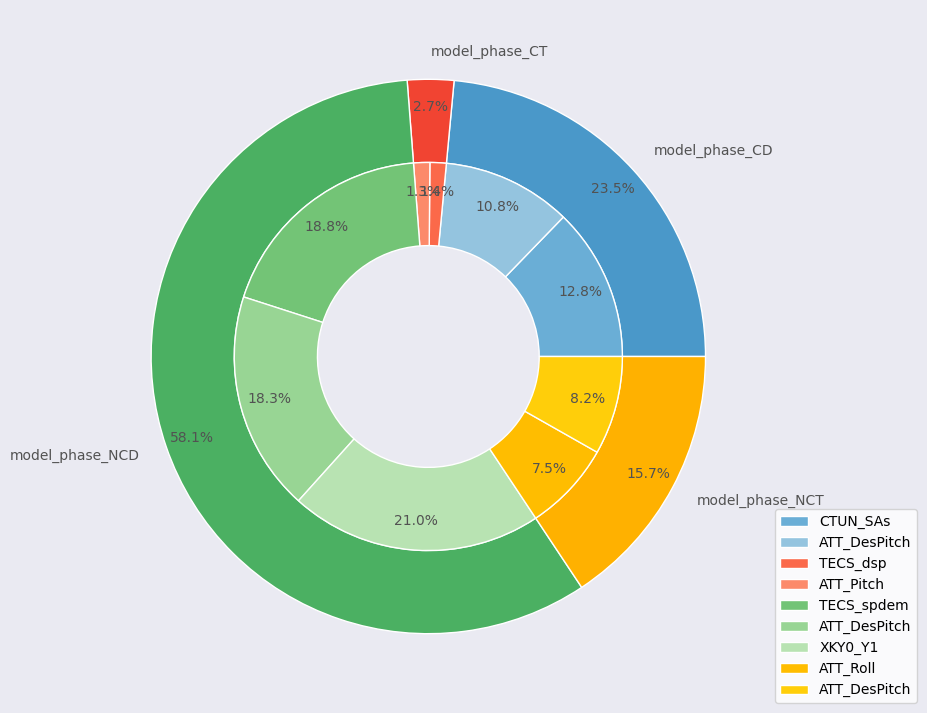

In [ ]:
facecolor = '#eaeaf2'
font_color = '#525252'
hfont = {'fontname':'Calibri'}
labels = ["model_phase_CD", "model_phase_CT", "model_phase_NCD", "model_phase_NCT"]
size = 0.3
vals = df['ST_ratio']
group_sum = df.groupby('model')['ST_ratio'].sum()

fig, ax = plt.subplots(figsize=(15,9), facecolor=facecolor)
a,b,c,d = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens ,plt.cm.Wistia ]

outer_colors = [a(.6), b(.6), c(.6), d(.6)]
inner_colors = [a(.5), a(.4),
                b(.5), b(.4),
                c(.5), c(.4), c(.3),
                d(.5), d(.4),]

ax.pie(group_sum,
       radius=1,
       colors=outer_colors,
       labels=labels,
       autopct='%1.1f%%',
       textprops={'color':font_color},
       wedgeprops=dict(width=size, edgecolor='w'),
       pctdistance=0.9)

wedges, texts, autotexts  = ax.pie(vals,
       radius=1-size, # size=0.3
       colors=inner_colors,
      #  labels=flattened_list,
       autopct='%1.1f%%',  # ใส่ autopct ในนี้
       textprops={'color':font_color},
       wedgeprops=dict(width=size, edgecolor='w'),
       pctdistance=0.85)  # กำหนดระยะห่างระหว่าง Label กับ Pie Chart

ax.legend(wedges, flattened_list, loc=(0.5, 0.5), bbox_to_anchor=(1, 0))


#shapley

In [ ]:
def run_shaley_analysis(X, y):
    temp = pd.concat([X,y],axis=1)
    shapley_result = shapley_r2.shapley_decomposition(temp,force=True)
    return shapley_result

x = run_shaley_analysis(X_test_CD, y_test_CD)
x['contribution'].tolist()

[0.4239093443959787, 0.5760906556040213]

In [ ]:
def run_shaley_analysis(X, y):
    temp = pd.concat([X,y],axis=1)
    shapley_result = shapley_r2.shapley_decomposition(temp,force=True)
    return shapley_result

datasets = [(X_test_CD, y_test_CD), (X_test_CT, y_test_CT), (X_test_NCD, y_test_NCD), (X_test_NCT, y_test_NCT)]

total_energy = sum([dataset[1].sum() for dataset in datasets])

shapley_results = [run_shaley_analysis(datasets[i][0], datasets[i][1]) for i in range(4)]

model_names = ['model_phase_CD', 'model_phase_CT', 'model_phase_NCD', 'model_phase_NCT']
variable_names_list = [datasets[i][0].columns.tolist() for i in range(4)]
flattened_list = [item for sublist in variable_names_list for item in sublist]
df_list = []

for i, result in enumerate(shapley_results):
    shapley_indices = result['contribution'].tolist()
    total_energy = datasets[i][1].sum()
    for j, shapley_index in enumerate(shapley_indices):
        df_list.append({
            'model': model_names[i],
            'variable': variable_names_list[i][j],
            'Shaley_ratio': shapley_index * total_energy
        })

df = pd.DataFrame(df_list)
df = df.pivot_table('Shaley_ratio', ['model', 'variable'])

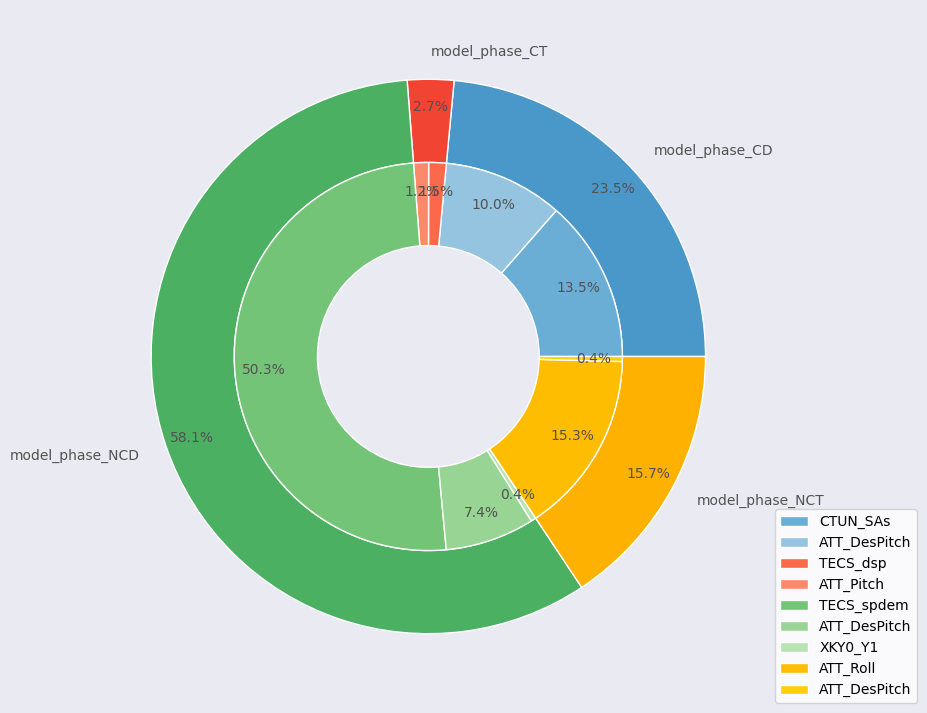

In [ ]:
facecolor = '#eaeaf2'
font_color = '#525252'
hfont = {'fontname':'Calibri'}
labels = ["model_phase_CD", "model_phase_CT", "model_phase_NCD", "model_phase_NCT"]
size = 0.3
vals = df['Shaley_ratio']
group_sum = df.groupby('model')['Shaley_ratio'].sum()

fig, ax = plt.subplots(figsize=(15,9), facecolor=facecolor)
a,b,c,d = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens ,plt.cm.Wistia ]

outer_colors = [a(.6), b(.6), c(.6), d(.6)]
inner_colors = [a(.5), a(.4),
                b(.5), b(.4),
                c(.5), c(.4), c(.3),
                d(.5), d(.4),]

ax.pie(group_sum,
       radius=1,
       colors=outer_colors,
       labels=labels,
       autopct='%1.1f%%',
       textprops={'color':font_color},
       wedgeprops=dict(width=size, edgecolor='w'),
       pctdistance=0.9)

wedges, texts, autotexts  = ax.pie(vals,
       radius=1-size, # size=0.3
       colors=inner_colors,
      #  labels=flattened_list,
       autopct='%1.1f%%',  # ใส่ autopct ในนี้
       textprops={'color':font_color},
       wedgeprops=dict(width=size, edgecolor='w'),
       pctdistance=0.85)  # กำหนดระยะห่างระหว่าง Label กับ Pie Chart

ax.legend(wedges, flattened_list, loc=(0.5, 0.5), bbox_to_anchor=(1, 0))